In [2]:
# # Install dependency libs, cartopy, etc
# !pip install --quiet dask_geopandas pyogrio cartopy

In [3]:
# # Install Times New Roman fonts, accepting license agreements automatically
# !sudo DEBIAN_FRONTEND=noninteractive apt-get install -y ttf-mscorefonts-installer

# # Update font cache
# !sudo fc-cache -fv

# # Remove matplotlib cache
# !rm ~/.cache/matplotlib -rf

In [1]:
from pathlib import Path
import pickle
import os
from tqdm import tqdm
import warnings
from multiprocessing import cpu_count

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import dask_geopandas
import dask.dataframe as dd

# Rebuild the font cache
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Filter warnings
warnings.filterwarnings("ignore")

In [2]:
print("The cpu count is:", cpu_count())

The cpu count is: 16


In [3]:
# Risk assessment folder
data_risk_ass = Path(".")

# ZCTA boundaries, business, and pop data folder
data_zcta_folder = Path(".")

# Data loc
data_loc = Path("..")

In [4]:
# Read the business and economic data at zcta levels
data_zcta_path = data_zcta_folder / "NAICS_EST_GDP2022_ZCTA.csv"
population_df_path = data_zcta_folder / "2020_decennial_census_at_ZCTA_level.csv"

# Reading data
data_zcta = pd.read_csv(data_zcta_path)
data_zcta["ZCTA"] = data_zcta["ZCTA"].astype(int)

# Read population data
population_df = pd.read_csv(population_df_path)
population_df["ZCTA"] = population_df["ZCTA"].astype(int)

# Merging and aggregating data
unique_zcta_regions = data_zcta[["ZCTA", "REGIONS", "STABBR"]].drop_duplicates()
regions_pop_df = unique_zcta_regions.merge(population_df, on=["ZCTA", "STABBR"])

In [5]:
def optimized_zcta_processing(data_zcta_folder, data_zcta):
    # Use dask_geopandas for reading large shapefiles
    zcta_gdf = dask_geopandas.read_file(data_zcta_folder / "tl_2020_us_zcta520.zip", npartitions=10)

    # Perform renaming and type conversion
    zcta_gdf = zcta_gdf.rename(columns={"ZCTA5CE20": "ZCTA"})
    zcta_gdf['ZCTA'] = zcta_gdf['ZCTA'].astype(int)

    # Calculate representative points (this operation might not be easily parallelizable)
    zcta_gdf['representative_point'] = zcta_gdf.geometry.representative_point()

    # Convert data_zcta to a dask dataframe if it's not already
    if not isinstance(data_zcta, dd.DataFrame):
        data_zcta = dd.from_pandas(data_zcta, npartitions=10)
        # Make ZCTA type int
        data_zcta['ZCTA'] = data_zcta['ZCTA'].astype(int)

    # Merge the dataframes
    zcta_business_gdf = data_zcta.merge(zcta_gdf[['ZCTA', 'geometry']], on='ZCTA', how='inner')

    # Compute the final result
    result = zcta_business_gdf.compute()

    return result

zcta_business_gdf = optimized_zcta_processing(data_zcta_folder, data_zcta)

In [6]:
# Make zcta_business_gdf geodataframe
zcta_business_gdf = gpd.GeoDataFrame(zcta_business_gdf, geometry="geometry")

zcta_business_gdf["points"] = zcta_business_gdf.geometry.representative_point()

# Set points as geometry
zcta_business_gdf.set_geometry("points", inplace=True)

# Convert to crs epsg:4326
zcta_business_gdf.to_crs(epsg=4326, inplace=True)

# Make the GDP daily
zcta_business_gdf['GDP2022'] = zcta_business_gdf['GDP2022'].apply(lambda x: x / 365)

In [7]:
# Read transformer information
transformer_info_path = data_risk_ass / "df_transformers.pkl"
with open(transformer_info_path, "rb") as f:
  transformer_info = pickle.load(f)

# Read substation to substation pkl
sub_2_sub_path = data_risk_ass / "substations_nodes.pkl"
with open(sub_2_sub_path, "rb") as f:
  sub_2_sub = pickle.load(f)

# Graph of sub connections/nodes
graph_path = data_risk_ass / "graph.pkl"
with open(graph_path, "rb") as f:
  G = pickle.load(f)

# Open substation and connected lines voltage ratings
substation_to_lines_path = data_risk_ass / "substation_to_line_voltages.pkl"
with open(substation_to_lines_path, "rb") as f:
  substation_to_lines = pickle.load(f)

In [8]:
# Load state gdf
states_gdf_path = data_zcta_folder  / "tl_2022_us_state.zip"
states_gdf = gpd.read_file(states_gdf_path)

# As EPSG 4326
states_gdf.to_crs(epsg=4326, inplace=True)

In [9]:
# Load the transmission lines data
transmission_lines_path = data_risk_ass / "tl_gdf_subset.pkl"
with open(transmission_lines_path, "rb") as f:
  transmission_lines = pickle.load(f)

# Rename LINE_ID to line_id, LINE_VOLTAGE to VOLTAGE
transmission_lines.rename(columns={"LINE_ID": "line_id", "LINE_VOLTAGE": "voltage"}, inplace=True)

# CRS epsg:4326
transmission_lines.to_crs(epsg=4326, inplace=True)

# Load all the substations fetched from open street map
subs_all_gdf_path = data_risk_ass / "ss_within_ferc.geojson"
subs_all_gdf = gpd.read_file(subs_all_gdf_path)

# To CRS
subs_all_gdf.to_crs(epsg=4326, inplace=True)

In [10]:
# Import random and select 5 random transformers or substations that might fail
import random
random.seed(42)

len_transformer_info = transformer_info.shape[0]

# Test of the code
# Select 5 random indices and loc the df
random_indices = random.sample(range(len_transformer_info), 50)
failed_transformers = transformer_info.loc[random_indices]
failed_transformers.head()

,sub_id,name,type,bus1,bus2,W1,W2,latitude,longitude
2619,181967059,T2620,Auto,3286,3285,0.04,0.06,32.988538,-109.275137
456,725474922,T457,GY-D,6157,6158,0.05,0.10,43.429241,-72.660130
102,159758306,T103,GY-GY,1642,1641,0.04,0.06,33.553368,-84.509471
3037,181134952,T3038,GY-D,3241,3242,0.05,0.10,40.633447,-77.577246
1126,187461477,T1127,GY-D,3829,3830,0.05,0.10,30.155538,-92.050256


In [11]:
from functools import reduce
from typing import Dict, List, Tuple

def get_connected_lines(sub: str, substation_to_lines: Dict[str, List[str]]) -> List[str]:
    """Get line IDs connected to a substation."""
    return substation_to_lines.get(sub, [])

# def create_substation_data(connected_sub: str, sub_2_sub: Dict[str, Dict], substation_to_lines: Dict[str, List[str]]) -> Dict[str, Dict]:
#     """Create data for a connected substation."""
#     return {
#         connected_sub: {
#             "subs": list(sub_2_sub[connected_sub].keys()),
#             "line_Ids": get_connected_lines(connected_sub, substation_to_lines)
#         }
#     }

# def process_substation(sub: str, sub_2_sub: Dict[str, Dict], substation_to_lines: Dict[str, List[str]]) -> Tuple[str, Dict]:
#     """Process a single substation and return its data."""
#     if not sub_2_sub[sub]:
#         return sub, {
#             "line_Ids": get_connected_lines(sub, substation_to_lines),
#             "subs": []
#         }
#     else:
#         connected_subs = list(sub_2_sub[sub].keys())
#         print(connected_subs)
#         sub_data = reduce(
#             lambda acc, conn_sub: {**acc, **create_substation_data(conn_sub, sub_2_sub, substation_to_lines)},
#             connected_subs,
#             {}
#         )
#         return sub, sub_data

def process_substation(sub: str, sub_2_sub: Dict[str, Dict], substation_to_lines: Dict[str, List[str]]) -> Tuple[str, Dict]:
    """Process a single substation and return its data."""
    connected_subs = list(sub_2_sub.get(sub, {}).keys())
    connected_lines = get_connected_lines(sub, substation_to_lines)
    
    sub_data = {
        "subs": connected_subs,
        "line_Ids": connected_lines
    }
    
    return sub, sub_data

def process_all_substations(sub_2_sub: Dict[str, Dict], substation_to_lines: Dict[str, List[str]]) -> Dict[str, Dict]:
    """Process all substations and return the complete data structure."""
    return {
        sub: process_substation(sub, sub_2_sub, substation_to_lines)[1]
        for sub in sub_2_sub.keys()
    }
    

def analyze_failed_transformers(failed_transformers: pd.DataFrame, sub_2_sub: Dict[str, Dict], substation_to_lines: Dict[str, List[str]]) -> Dict[str, Dict]:
    """Analyze failed transformers and their connected substations and lines."""
    return dict(map(
        lambda sub: process_substation(sub, sub_2_sub, substation_to_lines),
        failed_transformers.sub_id.values
    ))

failed_transformers_dict = analyze_failed_transformers(failed_transformers, sub_2_sub, substation_to_lines)

In [12]:
failed_transformers_dict

{181967059: {'subs': [163267075, 181967047, 181967050],
  'line_Ids': ['304038', '312896', '313961']},
 725474922: {'subs': [138917420, 138927367, 138912070],
  'line_Ids': ['150549', '113548', '122026']},
 159758306: {'subs': [171479107,
   180131624,
   159784560,
   171173868,
   159758304,
   171171652,
   159784569,
   159784542,
   159784551,
   171171654,
   171479142],
  'line_Ids': ['142660',
   '150324',
   '111933',
   '115171',
   '132137',
   '134035',
   '134119',
   '134145',
   '137813',
   '137922',
   '140190']},
 181134952: {'subs': [181134948], 'line_Ids': ['142229', '146026']},
 187461477: {'subs': [187461441, 187434304], 'line_Ids': ['113893', '119917']},
 837999443: {'subs': [837997890], 'line_Ids': ['109278']},
 171523305: {'subs': [159784541, 171523316], 'line_Ids': ['107132', '123053']},
 71583187: {'subs': [71516164, 435511383, 1224674505],
  'line_Ids': ['146527', '128626', '132794', '117988']},
 337935591: {'subs': [337944611, 579500908], 'line_Ids': ['3122

In [13]:
# Get the X and Y coordinates of the substations
subs_all_gdf["points"] = subs_all_gdf.geometry.representative_point()
subs_all_gdf["latitude"] = subs_all_gdf["points"].y
subs_all_gdf["longitude"] = subs_all_gdf["points"].x

In [14]:
def haversine_distance_and_components(lat1, lon1, lat2, lon2):
    # Earth's radius in km
    R = 6371

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c

    return distance / 1000

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import geopandas as gpd
from shapely.geometry import Polygon

# def get_unanalyzed_substations(failed_substation, failed_transformers_dict, analyzed_substations):
#     all_substations = {failed_substation}
#     for connected_sub, data in failed_transformers_dict[failed_substation].items():
#         if connected_sub not in analyzed_substations:
#             all_substations.add(connected_sub)
#             all_substations.update(sub for sub in data['subs'] if sub not in analyzed_substations)
#     return all_substations - analyzed_substations

def get_unanalyzed_substations(failed_substation, failed_transformers_dict, analyzed_substations):
    "Get connected substations"
    all_substations = {failed_substation}
    subs = failed_transformers_dict[failed_substation].get("subs", [])
    all_substations.update(sub for sub in subs if sub not in analyzed_substations)

    return all_substations - analyzed_substations

def create_voronoi_gdf(coordinates):
    points = np.array(list(coordinates.values()))
    vor = Voronoi(points)

    voronoi_polygons = []
    substations = []

    for point_idx, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 not in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            voronoi_polygons.append(polygon)
            substations.append(list(coordinates.keys())[point_idx])

    voronoi_gdf = gpd.GeoDataFrame({'geometry': voronoi_polygons, 'substation': substations})
    return voronoi_gdf.set_crs(epsg=4326)

def get_affected_businesses(zcta_assignment):
    bus_affected_gdf = zcta_assignment[~zcta_assignment.substation.isna()]
    grouped_business_affected = bus_affected_gdf.groupby(['NAICS'])[['EST', 'GDP2022']].sum()
    lat_lon_bus_affected_gdf = bus_affected_gdf[["ZCTA", "points"]].drop_duplicates()
    return grouped_business_affected, lat_lon_bus_affected_gdf

def calculate_distances(zctas, lat_lon, lat_lon_bus_affected_gdf, haversine_distance_and_components):
    distances = []
    for zcta in zctas:
        lat1, lon1 = lat_lon.latitude.values[0], lat_lon.longitude.values[0]
        lon2, lat2 = lat_lon_bus_affected_gdf.loc[lat_lon_bus_affected_gdf.ZCTA == zcta].points.x.values[0], lat_lon_bus_affected_gdf.loc[lat_lon_bus_affected_gdf.ZCTA == zcta].points.y.values[0]
        distance = haversine_distance_and_components(lat1, lon1, lat2, lon2)
        distances.append(distance)
    return distances

def analyze_economic_shocks(failed_transformers_dict, subs_all_gdf, zcta_business_gdf, regions_pop_df, haversine_distance_and_components):
    analyzed_substations = set()
    analyzed_zctas = set()
    economic_shocks_dict = {}

    for failed_substation in list(failed_transformers_dict.keys()):

        try:
          if failed_substation in analyzed_substations:
              failed_transformers_dict.pop(failed_substation)
              continue

          all_substations = get_unanalyzed_substations(failed_substation, failed_transformers_dict, analyzed_substations)

          if not all_substations:
              failed_transformers_dict.pop(failed_substation)
              continue

          analyzed_substations.update(all_substations)

          conn_substations_df = subs_all_gdf[subs_all_gdf.ss_id.isin(all_substations)]
          conn_substations_df['coordinates'] = list(zip(conn_substations_df.longitude, conn_substations_df.latitude))
          coordinates = dict(zip(conn_substations_df.ss_id, conn_substations_df.coordinates))

          voronoi_gdf = create_voronoi_gdf(coordinates)

          zcta_assignment = gpd.sjoin(
              zcta_business_gdf[~zcta_business_gdf.ZCTA.isin(analyzed_zctas)],
              voronoi_gdf,
              how="left",
              predicate="within"
          )

          grouped_business_affected, lat_lon_bus_affected_gdf = get_affected_businesses(zcta_assignment)

          analyzed_zctas.update(lat_lon_bus_affected_gdf.ZCTA.unique())

          zctas = lat_lon_bus_affected_gdf.ZCTA.unique()
          lat_lon = subs_all_gdf.loc[subs_all_gdf.ss_id == failed_substation]

          population_affected = regions_pop_df.loc[regions_pop_df.ZCTA.isin(zctas)].POP20.sum()

          distances = calculate_distances(zctas, lat_lon, lat_lon_bus_affected_gdf, haversine_distance_and_components)

          max_distance = max(distances) if distances else 0

          economic_shocks_dict[failed_substation] = {
              "coordinates": coordinates[failed_substation],
              "economic_shocks": grouped_business_affected,
              "max_distance": max_distance,
              "voronoi_gdf": voronoi_gdf,
              "total_gdp": grouped_business_affected.GDP2022.sum(),
              "total_est": grouped_business_affected.EST.sum(),
              "population_affected": population_affected,
          }
        except:
          failed_transformers_dict.pop(failed_substation)
          continue

    return economic_shocks_dict

# Usage
economic_shocks_results = analyze_economic_shocks(
    failed_transformers_dict,
    subs_all_gdf,
    zcta_business_gdf,
    regions_pop_df,
    haversine_distance_and_components
)

print(f"Analyzed {len(economic_shocks_results)} substations")
print("Finished analysis of economic shocks")

Analyzed 14 substations
Finished analysis of economic shocks


## Visualizations
**We will reuse code used in plotting GIC and hazard maps**

In [16]:
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import LineString
from shapely.ops import transform
import pyproj
from scipy import stats
import seaborn as sns

# NERC data_path
grid_regions_gdf = gpd.read_file(os.path.join(data_risk_ass, '..', 'nerc_gdf.geojson'))

In [17]:
# Set up map
def setup_map(ax, spatial_extent=[-125, -66.5, 24, 50]):
    ax.set_extent(spatial_extent, ccrs.PlateCarree())

    # Draw land first, with a light color
    ax.add_feature(cfeature.LAND, facecolor="#F0F0F0")
    ax.add_feature(cfeature.OCEAN, facecolor="#E0F0FF")

    # Add state boundaries on top
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.3, edgecolor="grey", alpha=0.4)

    # Coastlines and lakes for additional detail
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor="grey")
    ax.add_feature(cfeature.LAKES, alpha=0.5, linewidth=0.5, edgecolor="grey")

    gl = ax.gridlines(
        draw_labels=False, linewidth=0.2, color="grey", alpha=0.5, linestyle="--"
    )

    return ax

In [18]:
def format_with_commas(value, p=2):
    if p is None:
        return "{:,}".format(value)
    else:
        return "{:,.{precision}f}".format(value, precision=p)

In [19]:
def create_legend_scatter(bins, cmap, min_size=10, max_size=500):
    num_bins = len(bins) - 1
    y_pos = np.linspace(0, 1, num_bins)
    x_pos = np.full_like(y_pos, 0.5)
    sizes = np.logspace(np.log10(min_size), np.log10(max_size), num_bins)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, num_bins))

    return x_pos, y_pos, sizes, colors

def create_gic_bubble_legend(ax, bins, cmap, title='GIC (A)', legend_width=1, scale_factor=2):
    fig = ax.figure
    fig_width, fig_height = fig.get_size_inches()

    # Convert legend_width from inches to figure-relative units
    legend_width_fig = legend_width / fig_width

    # Get the position of the main axes in figure coordinates
    bbox = ax.get_position()

    # Calculate the legend position
    legend_left = bbox.x1 + 0.01  # Small gap between plot and legend
    legend_bottom = bbox.y0
    legend_height = bbox.height

    # Create the legend axes using figure coordinates
    legend_ax = fig.add_axes([legend_left, legend_bottom, legend_width_fig, legend_height])

    x_pos, y_pos, sizes, colors = create_legend_scatter(bins, cmap)

    # Adjust y_pos to prevent clipping
    y_padding = 0.05  # 5% padding at top and bottom
    y_pos = y_pos * (1 - 2*y_padding) + y_padding

    # Scale sizes based on legend width
    sizes = sizes * scale_factor

    legend_ax.scatter(x_pos, y_pos, s=sizes, c=colors, alpha=0.8, edgecolors=colors)

    legend_ax.set_xlim(0, 1)
    legend_ax.set_ylim(0, 1)
    legend_ax.set_xticks([])
    legend_ax.yaxis.tick_right()

    # Set y-ticks to match bin locations
    y_ticks = y_pos
    legend_ax.set_yticks(y_ticks)

    # Format labels with commas
    y_labels = [format_with_commas(int(val), p=None) for val in bins[:-1]]
    legend_ax.set_yticklabels(y_labels, fontsize=7)

    legend_ax.set_title(title, fontsize=7, pad=5)

    return legend_ax

def get_discrete_sizes_and_colors(gic_values, cmap, min_size=10, max_size=500, num_bins=5, global_min=None, global_max=None):
    abs_gic_values = np.abs(gic_values)

    if global_min is None:
        global_min = abs_gic_values.min()
    if global_max is None:
        global_max = abs_gic_values.max()

    # Apply log transformation to handle large range
    log_values = np.log1p(abs_gic_values)
    log_min = np.log1p(global_min)
    log_max = np.log1p(global_max)

    # Use quantile-based binning
    bins = stats.mstats.mquantiles(log_values, np.linspace(0, 1, num_bins + 1))

    # Ensure the last bin includes the maximum value
    bins[-1] = log_max

    # Digitize log_values into bins
    bin_indices = np.clip(np.digitize(log_values, bins) - 1, 0, num_bins - 1)

    # Define sizes using a power scale
    size_range = np.logspace(np.log10(min_size), np.log10(max_size), num_bins)
    discrete_sizes = size_range[bin_indices]

    # Define colors using a perceptually uniform colormap
    cmap_obj = plt.get_cmap(cmap)
    color_range = np.linspace(0, 1, num_bins)
    discrete_colors = cmap_obj(color_range)[bin_indices]

    # Calculate bin edges in original scale for interpretation
    bin_edges = np.expm1(bins)

    return discrete_sizes, discrete_colors, bin_edges

def plot_economic_impact(ax, coordinates, quant_values, cmap, alpha=0.8, min_size=10, max_size=500, zorder=3, global_min=None, global_max=None, legend_width=0.7, scale_factor=2, num_bins=10):
    plot_sizes, plot_colors, bins = get_discrete_sizes_and_colors(
        quant_values, cmap, min_size, max_size, global_min=global_min, global_max=global_max, num_bins=num_bins
    )

    lons = coordinates[:, 0]
    lats = coordinates[:, 1]
    plot_sizes = plot_sizes * scale_factor

    scatter = ax.scatter(lons, lats,
                         transform=ccrs.PlateCarree(),
                         c=plot_colors, s=plot_sizes,
                         alpha=alpha, edgecolors=plot_colors,
                         zorder=zorder)

    norm = colors.Normalize(vmin=bins[0], vmax=bins[-1])

    return scatter, bins, plt.get_cmap(cmap), norm

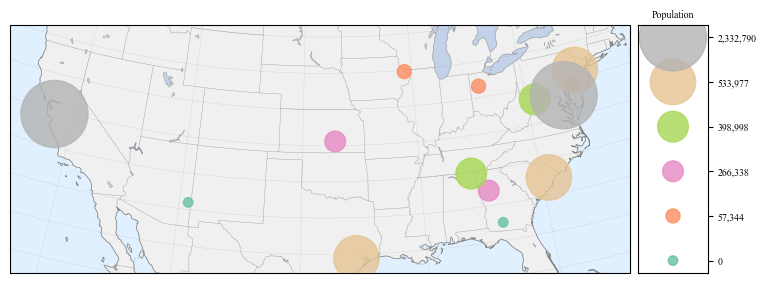

In [20]:
projection = ccrs.LambertConformal(central_longitude=-98, central_latitude=39.5)
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(1, 1, figure=fig, wspace=0.3, hspace=0.01)

ax = fig.add_subplot(gs[0, 0], projection=projection)

economic_shocks_dict = economic_shocks_results.copy()

# GDP impact
gdp = [economic_shocks_dict[sub]["total_gdp"] for sub in economic_shocks_dict.keys()]
coordinates = np.array([economic_shocks_dict[sub]["coordinates"] for sub in economic_shocks_dict.keys()])
population_affected = [economic_shocks_dict[sub]["population_affected"] for sub in economic_shocks_dict.keys()]

# Check the max, and min bounds of the coordinates - use it to set up cartopy map
x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()

legend_width = 0.7
scale_factor = legend_width / 0.15

spatial_extent = [x_min - 1, x_max + 1, y_min - 1, y_max + 1]
ax = setup_map(ax, spatial_extent=spatial_extent)

# # GDP impact
# scatter, bins, cmap, norm = plot_economic_impact(ax, coordinates, gdp, cmap="Set1", legend_width=legend_width, scale_factor=scale_factor, num_bins=6)
# create_gic_bubble_legend(ax, bins, cmap, title='GDP ($mn)', legend_width=legend_width, scale_factor=scale_factor)

# Population impact
scatter, bins, cmap, norm = plot_economic_impact(ax, coordinates, population_affected, cmap="Set2", legend_width=legend_width, scale_factor=scale_factor, num_bins=6)
create_gic_bubble_legend(ax, bins, cmap, title='Population', legend_width=legend_width, scale_factor=scale_factor)

plt.tight_layout()
plt.show()

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from shapely.geometry import Point
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

def setup_substation_map(ax, coords_bounds, zoom_radius=0.2):
    """
    Set up a detailed map centered on a specific substation.

    :param ax: Matplotlib axis object
    :param substation_lon: Longitude of the substation
    :param substation_lat: Latitude of the substation
    :param zoom_radius: Radius around the substation to show (in degrees)

    """
    min_lon, min_lat, max_lon, max_lat = coords_bounds

    # Set the map extent
    spatial_extent = [min_lon - zoom_radius, max_lon + zoom_radius, min_lat - zoom_radius, max_lat + zoom_radius]

    ax.set_extent(spatial_extent, ccrs.PlateCarree())

    # Add basic geographic features
    ax.add_feature(cfeature.LAND, facecolor="#F0F0F0")
    ax.add_feature(cfeature.OCEAN, facecolor="#E0F0FF")
    ax.add_feature(cfeature.COASTLINE, edgecolor="gray")
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    ax.add_feature(cfeature.LAKES, edgecolor="blue", facecolor="#E0F0FF", alpha=0.5)


    # Add urban areas
    urban_areas = cfeature.NaturalEarthFeature(
        category='cultural',
        name='urban_areas',
        scale='50m',
        facecolor='#D0D0D0',
        edgecolor='none'
    )
    ax.add_feature(urban_areas, alpha=0.5)
    # Add place names using a more reliable method
    shpfilename = shapereader.natural_earth(resolution='10m',
                                            category='cultural',
                                            name='populated_places_simple')

    reader = shapereader.Reader(shpfilename)
    places = reader.records()

    for place in places:
        properties = place.attributes
        if 'pop_max' in properties and properties['pop_max'] > 500000:  # Filter for larger cities
            x, y = place.geometry.x, place.geometry.y
            if spatial_extent[0] <= x <= spatial_extent[1] and spatial_extent[2] <= y <= spatial_extent[3]:
                ax.plot(x, y, 'ko', markersize=3, transform=ccrs.PlateCarree())
                ax.text(x, y, properties['name'], fontsize=5,
                        ha='right', va='bottom', transform=ccrs.PlateCarree())

    return ax


In [22]:
def extract_line_coordinates(df, geometry_col='geometry', source_crs=None, target_crs=ccrs.PlateCarree()):
    """
    Extract line coordinates from a DataFrame with a geometry column, optionally transforming coordinates.

    Parameters:
    - df: DataFrame with geometry column containing LineString objects
    - geometry_col: name of the geometry column (default: 'geometry')
    - source_crs: The source CRS of the geometries (e.g., 'EPSG:4326' for WGS84)
    - target_crs: The target CRS (default: PlateCarree)

    Returns:
    - line_coordinates: list of numpy arrays containing line coordinates
    - valid_indices: list of indices of valid LineStrings
    """
    line_coordinates = []
    valid_indices = []

    # Set up coordinate transformation if needed
    # Ensure df is a GeoDataFrame
    if not isinstance(df, gpd.GeoDataFrame):
        df = gpd.GeoDataFrame(df, geometry=geometry_col)

    # Print the current CRS
    print("Current CRS:", df.crs)

    # Ensure the GeoDataFrame has a CRS
    if df.crs is None:
        print("Warning: GeoDataFrame has no CRS. Assuming it's already in the target CRS.")
    else:
        # Transform to target CRS if needed
        if df.crs != target_crs:
            df = df.to_crs(target_crs.proj4_init)

    for idx, linestring in enumerate(df[geometry_col]):
        if isinstance(linestring, LineString):
            coords = np.array(linestring.coords)
            if coords.ndim == 2 and coords.shape[1] >= 2:
                line_coordinates.append(coords[:, :2])
                valid_indices.append(idx)
            else:
                print(f"Skipping linestring at index {idx} with unexpected shape: {coords.shape}")
        else:
            print(f"Invalid LineString at index {idx}: {linestring}")

    return line_coordinates, valid_indices

In [23]:
def create_voltage_color_map(unique_vs):
    """Create a distinctive color map for voltage levels."""
    # Use a colorblind-friendly palette
    palette = sns.color_palette("colorblind", n_colors=len(unique_vs))
    return {v: palette[i] for i, v in enumerate(unique_vs)}

def plot_transmission_lines(ax, line_coordinates, values, voltage_color_map, line_width=1.4, alpha=0.8):
    if not line_coordinates:
        print("No valid line segments found.")
        return None

    line_width_vals = np.array(values)
    line_width_vals[line_width_vals == -999999.0] = 99

    # Scale the line widths
    scaled_widths = (line_width_vals / max(line_width_vals)) * line_width

    colors = [voltage_color_map[val] for val in line_width_vals]

    line_collection = LineCollection(
        line_coordinates,
        colors=colors,
        linewidths=scaled_widths,
        alpha=alpha,
        transform=ccrs.PlateCarree(),
    )

    ax.add_collection(line_collection)
    return line_collection

def scatter_substations(ax, failed_sub_coords, other_coords, state_name, population, gdp, est_count, min_size=10, max_size=40):
    other_color = '#1f77b4'
    failed_color = '#d62728'
    edge_color = '#2f2f2f'

    # Plot the substations
    ax.scatter(
        [coord[0] for coord in other_coords],
        [coord[1] for coord in other_coords],
        transform=ccrs.PlateCarree(),
        c=other_color,
        edgecolors=other_color,
        alpha=0.5,
        s=min_size,
    )

    ax.scatter(
        [failed_sub_coords[0]],
        [failed_sub_coords[1]],
        transform=ccrs.PlateCarree(),
        c=failed_color,
        edgecolors=failed_color,
        alpha=1.0,
        s=max_size,
        marker='*'
    )

    # Create custom legend elements
    legend_elements = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=other_color,
                      markersize=8, label='Linked Subs.'),
        mlines.Line2D([0], [0], marker='*', color='w', markerfacecolor=failed_color,
                      markersize=12, label='Failed Sub.'),
        mpatches.Patch(color='none', label=f'State: {state_name}'),
        mpatches.Patch(color='none', label=f'Pop. {population:.2f}M'),
        mpatches.Patch(color='none', label=f'GDP: ${gdp:,.0f}M'),
        mpatches.Patch(color='none', label=f'Est. {est_count:,}')
    ]

    return legend_elements

# Prepare voltage color map
unique_vs = np.append(transmission_lines.voltage.unique(), 99)
voltage_color_map = create_voltage_color_map(unique_vs)
source_crs = "EPSG:4326"

# Check if a point in what state
def get_state_from_coordinates(failed_substation_coords, states_gdf):
    """
    Get the state name from given coordinates using a GeoDataFrame of state boundaries.

    :param failed_substation_coords: Longitude and latitude of the failed substation
    :param states_gdf: GeoDataFrame containing state boundaries
    :return: State name or None if not found
    """
    # Extract longitude and latitude
    longitude, latitude = failed_substation_coords

    # Create a point from the coordinates
    point = Point(longitude, latitude)

    # Create a GeoDataFrame from the point
    point_gdf = gpd.GeoDataFrame(geometry=[point], crs=states_gdf.crs)

    # Perform spatial join
    joined = gpd.sjoin(point_gdf, states_gdf, how="left", predicate="within")


    # Check if a state was found
    if not joined.empty and 'NAME' in joined.columns:  # Assuming 'NAME' is the column with state names
        return joined.iloc[0]['NAME']
    else:
        return None

In [24]:
import warnings
import operator
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings("ignore")

In [25]:
def get_top_failed_substations(failed_transformers_dict, economic_shocks_dict, max_count=8):
    """
    Get the top failed substations based on population affected.

    :param failed_transformers_dict: Dictionary of failed transformers
    :param economic_shocks_dict: Dictionary containing economic impact data
    :param max_count: Maximum number of substations to return
    :return: List of top substation IDs
    """
    # Create a list of (substation_id, population_affected) tuples
    substation_impacts = [
        (substation, economic_shocks_dict[substation]['population_affected'])
        for substation in failed_transformers_dict.keys()
    ]

    # Sort the list by population affected in descending order
    sorted_substations = sorted(substation_impacts, key=operator.itemgetter(1), reverse=True)

    # Return the top max_count substations
    return [substation for substation, _ in sorted_substations[:max_count]]

In [26]:
def create_grid_visualization(economic_shocks_dict, failed_transformers_dict, subs_all_gdf,
                              transmission_lines, states_gdf, voltage_color_map):
    # Get top 4 failed substations
    top_failed_substations = get_top_failed_substations(failed_transformers_dict, economic_shocks_dict, max_count=4)

    # Create figure and grid layout
    fig = plt.figure(figsize=(8, 5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.01)

    # Create main overview map
    ax_main = fig.add_subplot(gs[0], projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=39.5))
    create_overview_map(ax_main, economic_shocks_dict)

    # Create a subfigure for zoomed views
    gs_zoom = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], wspace=0.01)

    # Sort substations from west to east
    sorted_substations = sorted(top_failed_substations,
                                key=lambda x: economic_shocks_dict[x]["coordinates"][0])

    # Create zoomed-in views
    for i, failed_substation in enumerate(sorted_substations):
        ax = fig.add_subplot(gs_zoom[i], projection=ccrs.PlateCarree())
        create_zoomed_view(ax, failed_substation, failed_transformers_dict, economic_shocks_dict,
                           subs_all_gdf, transmission_lines, states_gdf, voltage_color_map)

        # Add zoom effect lines
        coords = economic_shocks_dict[failed_substation]["coordinates"]
        main_coords = ax_main.projection.transform_point(*coords, ccrs.PlateCarree())

        # Left line
        con_left = ConnectionPatch(
            xyA=(0, 1), xyB=(main_coords[0], main_coords[1]),
            coordsA="axes fraction", coordsB=ax_main.transData,
            axesA=ax, axesB=ax_main, color="red", linestyle="-", alpha=0.5
        )
        fig.add_artist(con_left)

        # Right line
        con_right = ConnectionPatch(
            xyA=(1, 1), xyB=(main_coords[0], main_coords[1]),
            coordsA="axes fraction", coordsB=ax_main.transData,
            axesA=ax, axesB=ax_main, color="red", linestyle="-", alpha=0.5
        )
        fig.add_artist(con_right)

    # Adjust layout
    plt.tight_layout()
    # fig.subplots_adjust(top=0.95, bottom=0.05, left=0.02, right=0.98)

    plt.show()

    return fig, gs, gs_zoom

def create_overview_map(ax, economic_shocks_dict):
    coordinates = np.array([economic_shocks_dict[sub]["coordinates"] for sub in economic_shocks_dict.keys()])
    population_affected = [economic_shocks_dict[sub]["population_affected"] for sub in economic_shocks_dict.keys()]

    x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
    y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()
    spatial_extent = [x_min - 1, x_max + 1, y_min - 1, y_max + 1]
    setup_map(ax, spatial_extent=spatial_extent)

    legend_width = 0.7
    scale_factor = legend_width / 0.15
    scatter, bins, cmap, norm = plot_economic_impact(ax, coordinates, population_affected,
                                                     cmap="Set2", legend_width=legend_width,
                                                     scale_factor=scale_factor, num_bins=6)
    create_gic_bubble_legend(ax, bins, cmap, title='Population',
                             legend_width=legend_width, scale_factor=scale_factor)


def create_zoomed_view(ax, failed_substation, failed_transformers_dict, economic_shocks_dict,
                       subs_all_gdf, transmission_lines, states_gdf, voltage_color_map):

    all_substations = set()
    all_substations.add(failed_substation)
    all_transmission_lines = set()
    
    subs = failed_transformers_dict[failed_substation].get("subs", [])
    trans_lines = failed_transformers_dict[failed_substation].get("line_Ids", [])
    
    all_substations.update(subs)
    all_transmission_lines.update(trans_lines)


    # Connected substations df
    conn_substations_df = subs_all_gdf[subs_all_gdf.ss_id.isin(all_substations)]

    # Connected Transmission lines
    conn_transmission_lines_df = transmission_lines[transmission_lines.line_id.isin(all_transmission_lines)]

    # Zip longitude, latitude in failed_transformers
    conn_substations_df['coordinates'] = list(zip(conn_substations_df.longitude, conn_substations_df.latitude))

    # Failed trans coordinates - zip with sub ids
    failed_trans_coordinates = dict(zip(conn_substations_df.ss_id, conn_substations_df.coordinates))

    # failed_trans_coordinates array
    failed_coordinates_arr = np.array(list(failed_trans_coordinates.values()))

    # Get the bounds of the areas
    coords_bounds = failed_coordinates_arr.min(axis=0)[0], failed_coordinates_arr.min(axis=0)[1], failed_coordinates_arr.max(axis=0)[0], failed_coordinates_arr.max(axis=0)[1]

    # Failed substation coords
    failed_substation_coords = economic_shocks_dict[failed_substation]["coordinates"]

    # Make array from dict values
    failed_trans_coordinates = np.array(list(failed_trans_coordinates.values()))

    # Extract coordinates once, transforming if needed
    line_coordinates, valid_indices = extract_line_coordinates(conn_transmission_lines_df, source_crs=source_crs)

    # Socio economic params
    gdp = economic_shocks_dict[failed_substation]['total_gdp']
    population = economic_shocks_dict[failed_substation]['population_affected'] / 1e6
    est_count = economic_shocks_dict[failed_substation]['total_est']

    # State location
    state_name = get_state_from_coordinates(failed_substation_coords, states_gdf)

    # Line Voltage Ratings
    line_voltage_ratings = conn_transmission_lines_df.voltage.values

    # Plot the map
    ax = setup_substation_map(ax, coords_bounds, zoom_radius=0.2)

    center_lon, center_lat = failed_substation_coords

    # Plot transmission lines
    plot_transmission_lines(ax, line_coordinates, transmission_lines.voltage, voltage_color_map)

    # Plot substations
    legend_elements = scatter_substations(ax, failed_substation_coords, failed_trans_coordinates,
                          state_name, population, gdp, est_count)

    ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(-0.1, -1),
           ncol=1, fontsize=6, frameon=False)

## Economic Impact analysis

In [27]:
class InputOutputModel:

    def __init__(self, data_path, value_added=None, final_demand=None):
        self.final_demand = final_demand
        self.value_added = value_added
        self.data_path = data_path
        self.load_input_data()
        self.calculate_B_matrix()

    def load_input_data(self):
        """
        Load the input data.

        Parameters:
        None
        """

        # Technical coefficients matrix
        self.technology_matrix = pd.read_csv(
            os.path.join(self.data_path, "direct_requirements.csv")
        )

        # A matrix (trim the value added in the io matrix)
        self.A = self.technology_matrix.iloc[:15].to_numpy()

        # Identity matrix
        self.I = np.eye(self.A.shape[1])

        # Real 2022 US gross output by industires, in billion dollars
        self.industry_output = pd.read_csv(
            os.path.join(self.data_path, "us_gross_output.csv"), usecols=["2022Q3"]
        ).to_numpy().reshape(-1)

    def calculate_B_matrix(self):
        # Diagonalize the industry output (x_hat)
        gross_diag = np.diag(self.industry_output)

        # Invverse of the diagonalized industry output (x_hat^-1)
        gross_diag_inv = np.linalg.inv(gross_diag)

        # Compute the B matrix
        self.B = np.dot(np.dot(gross_diag_inv, self.A), gross_diag)

    def leontief(self):
        """
        Calculate the Leontief model.
        L = (I - A)^-1 add X = L * final_demand

        Parameters:
        final_demand (numpy.ndarray): The final demand vector.

        Returns:
        numpy.ndarray: The output vector representing the total output of each sector.
        """

        if (self.final_demand.any()):
            return np.linalg.inv(self.I - self.A).dot(self.final_demand)

    def ghosh(self):
        """
        Calculate the supply chain impacts due to change in value added.
        B = X_hat^-1 * A * X_hat and Ghosh = (I - B)^-1
        Change in Gross output is v' @ Ghosh

        Parameters:
        None

        Returns:
        numpy.ndarray: The total downstream impacts.
        """
        if (self.value_added.any()):

            # Ghosh model
            self.ghosh_model = np.linalg.inv(self.I - self.B)

            # Transpose value added
            va_transposed = np.transpose(self.value_added)

            # Change in Gross output is v' @ Ghosh
            delta_va = va_transposed @ self.ghosh_model

            return delta_va

In [28]:
# NAICS code and industry concordance
NAICSIndustries = {
    "11": "Agriculture, forestry, and fishing",
    "21": "Mining, quarrying, and gas extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "42": "Wholesale Trade",
    "44": "Retail Trade",
    "48": "Transportation and Warehousing",
    "51": "Information",
    "FIRE": "Finance, insurance, and real estate",
    "PROF": "Professional and business services",
    "6": "Educational, health, and social assistance",
    "7": "Arts, entertainment and food",
    "81": "Other (except public admin)",
    "G": "Government",
}

# Create a sorting key based on NAICSIndustries keys
sort_key = {code: i for i, code in enumerate(NAICSIndustries.keys())}

def sum_economic_shocks(economic_shocks_dict):
    # List to store all economic shock dataframes
    all_economic_shocks = []

    for failed_sub in list(economic_shocks_dict.keys()):
        economic_shocks_df = economic_shocks_dict[failed_sub]["economic_shocks"]
        all_economic_shocks.append(economic_shocks_df)

    # Concatenate all dataframes
    combined_shocks = pd.concat(all_economic_shocks)

    # Group by NAICS and sum EST and GDP2022
    total_econ_shock = combined_shocks.groupby('NAICS').agg({
        'EST': 'sum',
        'GDP2022': 'sum'
    }).reset_index()

    return total_econ_shock

def pad_missing_naics(va, NAICSIndustries):
    # Create a full set of NAICS codes
    all_naics = pd.Index(NAICSIndustries.keys())

    # Reindex the DataFrame, adding missing NAICS codes and filling with zeros
    va_padded = va.reindex(all_naics, fill_value=0)

    return va_padded

def get_value_added(economic_shocks_dict):

  total_econ_shock = sum_economic_shocks(economic_shocks_dict)
  va = total_econ_shock.copy()
  va.set_index('NAICS', inplace=True)

  # If NAICS code is missing, create and assign GDP2022, and Assignmenet zero
  va = pad_missing_naics(va, NAICSIndustries)
  va = va.assign(EST=va.EST.fillna(0), GDP2022=va.GDP2022.fillna(0))

  va = va.sort_index(key=lambda x: x.map(sort_key.get))
  va['NAICS'] = va.index
  va['NAICSIndustries'] = va['NAICS'].map(NAICSIndustries)

  # Ghosh model
  io_model = InputOutputModel(data_path=data_zcta_folder, value_added=va["GDP2022"].to_numpy())
  delta_va = io_model.ghosh()

  # Total impact
  va["total_shocks"] = delta_va

  # Indirect impact
  va["indirect_shocks"] = va["total_shocks"] - va["GDP2022"]

  # Prepare the data
  va = va[['NAICSIndustries', 'GDP2022', 'indirect_shocks']]
  va = va.rename(columns={'GDP2022': 'Direct Impact', 'indirect_shocks': 'Indirect Impact'})

  # Calculate total impact and sort
  va['Total Impact'] = va['Direct Impact'] + va['Indirect Impact']

  return va


In [29]:
def indirect_impact_plot(plot_data):
  # Create a figure and axis
  # Create the plot
  fig, ax = plt.subplots(figsize=(8, len(plot_data) * 0.2))

  # Plot stacked bars
  ax.barh(plot_data['NAICSIndustries'], plot_data['Direct Impact'],
          label='Direct Impact', color='#1f77b4')
  ax.barh(plot_data['NAICSIndustries'], plot_data['Indirect Impact'],
          left=plot_data['Direct Impact'], label='Indirect Impact', color='#ff7f0e')

  # Customize the plot
  ax.set_title('Daily Direct and Indirect Economic Impact by NAICS Industry', fontsize=11, loc="left")
  ax.set_xlabel('Economic Impact ($Mn)', fontsize=8)
  ax.set_ylabel('NAICS Industries', fontsize=8)
  ax.legend(title='Impact Type', loc='lower right', frameon=False)

  ax.set_ylim(-0.5, len(plot_data) - 0.5)

  # Adjust y-axis labels for readability
  plt.yticks(fontsize=6)

  # Format x-axis with commas
  ax.xaxis.set_major_formatter(FuncFormatter(format_with_commas))

  # Add thin grey grid lines
  ax.grid(True, axis='x', linestyle='--', linewidth=0.2, color='grey', alpha=0.5)

  # Add y grid lines
  ax.grid(True, axis='y', linestyle='--', linewidth=0.2, color='grey', alpha=0.5)

  # Set the figure facecolor to match the axes
  fig.patch.set_facecolor('#F0F0F0')

  ax.set_facecolor('#F0F0F0')

  # Adjust layout and display
  plt.tight_layout()
  plt.show()

  return fig

In [30]:
def get_failed_transformers(gic_file_path):
    # Load transformers and GIC vals for different space weather scenarios
    df_gic_100 = pd.read_csv(gic_file_path)
    df_gic_100['gic'] = df_gic_100['gic'].apply(lambda x: eval(x))

    # Use the storm and simulated data
    df = df_gic_100.copy()

    plot_order = [
        (1, 0, "Auto", "i_c"),
        (1, 1, "Auto", "i_s"),
        (2, 0, "GY-GY/GY-GY-D/GY-D", "i_w1"),
        (2, 1, "GY-GY/GY-GY-D", "i_w2"),
    ]

    dfs = []

    for i, (row, col, transformer_type, gic_column) in enumerate(plot_order):
        if transformer_type == "GY-GY/GY-GY-D":
            df_type = df[df["type"].isin(["GY-GY-D", "GY-GY"])]
        elif transformer_type == "GY-GY/GY-GY-D/GY-D":
            df_type = df[df["type"].isin(["GY-GY-D", "GY-GY", "GY-D"])]
        else:
            df_type = df[df["type"] == transformer_type]

        gic_values = df_type["gic"].tolist()
        all_keys = set()
        for item in gic_values:
            all_keys.update(item.keys())

        for key in all_keys:
            df_type[key] = [item.get(key, 0) for item in gic_values]

        if "i_s" in df_type.columns:
            df_type.rename(columns={"i_s": "pri"}, inplace=True)
        if "i_w1" in df_type.columns:
            df_type.rename(columns={"i_w1": "pri"}, inplace=True)

        useful_cols = ['sub_id', 'name', 'type', 'latitude', 'longitude', 'pri']
        dfs.append(df_type[useful_cols])

    failed_transformers = pd.concat(dfs)
    failed_transformers['pri_abs'] = failed_transformers['pri'].apply(lambda x: np.abs(float(x)))

    # Filter only within NERC threshold of 75 A >
    failed_transformers = failed_transformers[failed_transformers['pri_abs'] >= 75]
    failed_transformers.drop_duplicates(inplace=True)

    return failed_transformers

In [31]:
def get_failed_transformers(gic_file_path, col = "Gannon A/ph"):

  df_gic = pd.read_csv(gic_file_path)
  # Use the storm and simulated data
  df = df_gic.copy()
  plot_order = [
        (1, 0, "Auto", "Common"),
        (1, 1, "Auto", "Series"),
        (2, 0, "GY-GY/GY-GY-D/GY-D", "HV"),
        (2, 1, "GY-GY/GY-GY-D", "LV"),
    ]

  dfs = []

  df = df[(df["Winding"] == "HV") | (df["Winding"] == "Series")]

  df.rename(columns={col : "pri"}, inplace=True)
  useful_cols = ['sub_id', "Transformer", 'latitude', 'longitude', 'pri']
  failed_transformers = df[useful_cols]

  failed_transformers['pri_abs'] = failed_transformers['pri'].apply(lambda x: np.abs(float(x)))

  # Filter only within NERC threshold of 75 A >
  failed_transformers = failed_transformers[failed_transformers['pri_abs'] >= 75]
  failed_transformers.drop_duplicates(subset="sub_id", inplace=True)

  return failed_transformers

In [32]:
def econ_impact_viz(failed_transformers, sub_2_sub, substation_to_lines, subs_all_gdf,
         zcta_business_gdf, regions_pop_df, haversine_distance_and_components,
         transmission_lines, states_gdf, voltage_color_map):

    # Get a dictionary of failed transformers
    failed_transformers_dict = analyze_failed_transformers(failed_transformers, sub_2_sub, substation_to_lines)

    # Get economic shocks incurred by the population
    # economic_shocks_dict = {
    #     failed_substation: analyze_economic_shocks(
    #         failed_substation, failed_transformers_dict, subs_all_gdf,
    #         zcta_business_gdf, regions_pop_df, haversine_distance_and_components
    #     )
    #     for failed_substation in failed_transformers_dict.keys()
    # }

    economic_shocks_dict = analyze_economic_shocks(
      failed_transformers_dict,
      subs_all_gdf,
      zcta_business_gdf,
      regions_pop_df,
      haversine_distance_and_components
    )

    economic_impact_fig = indirect_impact_plot(get_value_added(economic_shocks_dict))
    # Save the plot for further visualizations
    economic_impact_fig.savefig('economic_impact_by_naics.png', dpi=300, bbox_inches='tight')

    # Plot of the regions with failed transformers
    fig, gs, gs_zoom = create_grid_visualization(economic_shocks_dict, failed_transformers_dict, subs_all_gdf,
                              transmission_lines, states_gdf, voltage_color_map)

    # Save fig
    fig.savefig('grid_visualization.png', dpi=300, bbox_inches='tight')

       sub_id Transformer   latitude  longitude         pri     pri_abs
268  14433409        T494  34.793669 -82.895174 -115.440245  115.440245
504  82442537       T1001  37.502674 -77.704012  -93.931618   93.931618


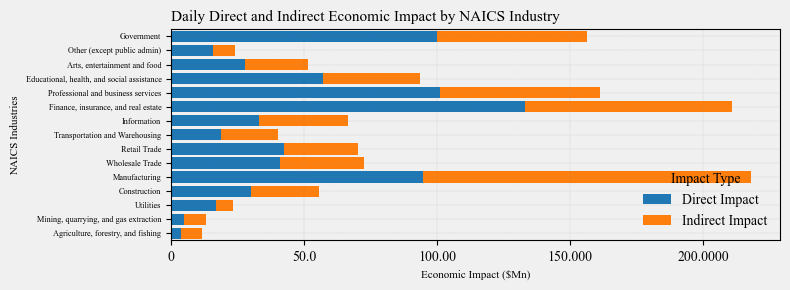

Current CRS: EPSG:4326
Current CRS: EPSG:4326


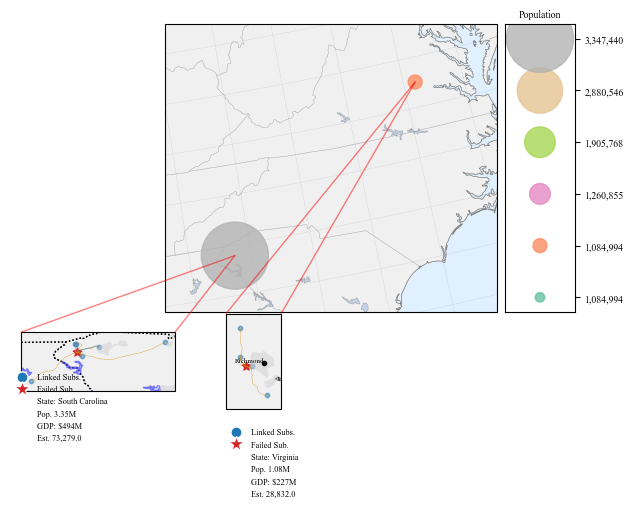

In [33]:
path_data = "../winding_gic.csv"
failed_transformers = get_failed_transformers(path_data)

# Viz
econ_impact_viz(failed_transformers, sub_2_sub, substation_to_lines, subs_all_gdf,
         zcta_business_gdf, regions_pop_df, haversine_distance_and_components,
         transmission_lines, states_gdf, voltage_color_map)

In [34]:
# # Load 1000 year event gic
# df_gic_1000_path = data_risk_ass / ".." / "gic_1000.csv"
# failed_transformers = get_failed_transformers(df_gic_1000_path)

# # Viz
# econ_impact_viz(failed_transformers, sub_2_sub, substation_to_lines, subs_all_gdf,
#          zcta_business_gdf, regions_pop_df, haversine_distance_and_components,
#          transmission_lines, states_gdf, voltage_color_map)

### Exceedance Probabilities of Transformer Failures
Will use  tr withstand vals of 75 A/phfor GIC flowing in primary of GY_GY, GY_GY_D, and GSU and serial winding of Autotransformers. For failure analysis, each transformer has equal rate of failure due to THD, voltage instabiluity or failure of protective systems due to odd and even harmonics

In [35]:
import itertools
from tqdm import tqdm

In [36]:
def create_combinations(failed_transformers, max_combinations=1000000):
    """
    Create combinations of substation failures, using sampling for large sets.

    :param failed_transformers: DataFrame containing transformer information
    :param max_combinations: Threshold for switching to sampling (default 1,000,000)
    :return: DataFrame of combinations
    """
    substations = failed_transformers.sub_id.unique()
    n_substations = len(substations)
    total_combinations = 2 ** n_substations

    if total_combinations <= max_combinations:
        # Generate all combinations
        combinations = list(itertools.product([0, 1], repeat=n_substations))
        df_combinations = pd.DataFrame(combinations, columns=substations)
        print(f"Generated all {total_combinations} combinations.")
    else:
        # Sample combinations
        sample_size = max_combinations
        samples = np.random.randint(2, size=(sample_size, n_substations))
        df_combinations = pd.DataFrame(samples, columns=substations)
        print(f"Sampled {sample_size} out of {total_combinations} possible combinations.")

    return df_combinations

In [37]:
def create_economic_shocks(file_path, col):

  failed_transformers = get_failed_transformers(file_path, col)

  df_combinations = create_combinations(failed_transformers)

  # Get a dictionary of failed transformers
  failed_transformers_dict = analyze_failed_transformers(failed_transformers, sub_2_sub, substation_to_lines)

  economic_shocks_dict = analyze_economic_shocks(
    failed_transformers_dict,
    subs_all_gdf,
    zcta_business_gdf,
    regions_pop_df,
    haversine_distance_and_components
  )

  return economic_shocks_dict, df_combinations

In [38]:
# Map the df combinations by col
def calculate_economic_impact(file_path, col):
    # Economic shocks
    economic_shocks_dict, df_combinations = create_economic_shocks(file_path, col)

    # Create a dictionary to store GDP values for each substation
    substation_gdp = {substation: data['total_gdp'] for substation, data in economic_shocks_dict.items()}

    # Create a new DataFrame to store the results
    df_impact = df_combinations.copy()

    # Calculate the total GDP impact for each combination
    for substation in substation_gdp.keys():
        if substation in df_impact.columns:
            df_impact[f'{substation}_gdp_impact'] = df_impact[substation] * substation_gdp[substation]

    # Calculate the total GDP impact for each combination
    gdp_impact_columns = [col for col in df_impact.columns if str(col).endswith('_gdp_impact')]
    df_impact['total_gdp_impact'] = df_impact[gdp_impact_columns].sum(axis=1)

    # Calculate other metrics
    df_impact['num_substations_failed'] = df_combinations.sum(axis=1)
    df_impact['percent_gdp_impact'] = df_impact['total_gdp_impact'] / sum(substation_gdp.values()) * 100

    return df_impact, economic_shocks_dict

In [39]:
nulls_dict = {'NAICSIndustries': {'11': 'Agriculture, forestry, and fishing',
  '21': 'Mining, quarrying, and gas extraction',
  '22': 'Utilities',
  '23': 'Construction',
  '31': 'Manufacturing',
  '42': 'Wholesale Trade',
  '44': 'Retail Trade',
  '48': 'Transportation and Warehousing',
  '51': 'Information',
  'FIRE': 'Finance, insurance, and real estate',
  'PROF': 'Professional and business services',
  '6': 'Educational, health, and social assistance',
  '7': 'Arts, entertainment and food',
  '81': 'Other (except public admin)',
  'G': 'Government'},
 'Direct Impact': {'11': 0,
  '21': 0,
  '22': 0,
  '23': 0,
  '31': 0,
  '42': 0,
  '44': 0,
  '48': 0,
  '51': 0,
  'FIRE': 0,
  'PROF': 0,
  '6': 0,
  '7': 0,
  '81': 0,
  'G': 0},
 'Indirect Impact': {'11': 0,
  '21': 0,
  '22': 0,
  '23': 0,
  '31': 0,
  '42': 0,
  '44': 0,
  '48': 0,
  '51': 0,
  'FIRE': 0,
  'PROF': 0,
  '6': 0,
  '7': 0,
  '81': 0,
  'G': 0},
 'Total Impact': {'11': 0,
  '21': 0,
  '22': 0,
  '23': 0,
  '31': 0,
  '42': 0,
  '44': 0,
  '48': 0,
  '51': 0,
  'FIRE': 0,
  'PROF': 0,
  '6': 0,
  '7': 0,
  '81': 0,
  'G': 0}}

df_nulls = pd.DataFrame(nulls_dict)

In [40]:
# Get substations that coincide with 5%, 50%, and 95%
def find_percentile_indices(df_impact, economic_shocks_dict, percentiles=[5, 50, 95]):
    # Sort the DataFrame by total_gdp_impact
    df_sorted = df_impact.sort_values('total_gdp_impact').reset_index(drop=True)

    # Calculate the percentile values
    percentile_values = np.percentile(df_sorted['total_gdp_impact'], percentiles)

    # Find the indices of the nearest matching values
    indices = []
    for value in percentile_values:
        idx = (df_sorted['total_gdp_impact'] - value).abs().idxmin()

        if not np.isnan(idx):
            indices.append(idx)

    # Create a result DataFrame
    result = pd.DataFrame({
        'Percentile': percentiles,
        'GDP_Impact': percentile_values,
        'Nearest_Index': indices
    })

    # Query the substations in df_sorted
    result_df = df_sorted.iloc[result['Nearest_Index']]

    # Get only those columns whose names are integers (assuming these are substation IDs)
    cols = [col for col in result_df.columns if isinstance(col, int)]

    # Create a dictionary with failed substations for each percentile
    result_dict = {}
    for i, (_, row) in enumerate(result_df[cols].iterrows()):
        percentile = percentiles[i]
        failed_substations = [col for col in cols if row[col] == 1]
        result_dict[percentile] = failed_substations

    # 5 percentile
    percentile_5_economic_dict = {
        failed_substation: economic_shocks_dict[failed_substation]
        for failed_substation in result_dict[5] if failed_substation in economic_shocks_dict
    }
    if percentile_5_economic_dict == {}:
      percentile_5_va = df_nulls
    else:
      percentile_5_va = get_value_added(percentile_5_economic_dict)

    # 50th percentile
    percentile_50_economic_dict = {
        failed_substation: economic_shocks_dict[failed_substation]
        for failed_substation in result_dict[50] if failed_substation in economic_shocks_dict
    }
    if percentile_50_economic_dict == {}:
      percentile_50_va = df_nulls
    else:
      percentile_50_va = get_value_added(percentile_50_economic_dict)

    # 95th percentile
    percentile_95_economic_dict = {
        failed_substation: economic_shocks_dict[failed_substation]
        for failed_substation in result_dict[95] if failed_substation in economic_shocks_dict
    }
    if percentile_95_economic_dict == {}:
      percentile_95_va = df_nulls
    else:
      percentile_95_va = get_value_added(percentile_95_economic_dict)

    return percentile_5_va, percentile_50_va, percentile_95_va

In [41]:
def plot_cf_curve(df_impact):
    # Sort the GDP impacts in ascending order
    sorted_impacts = np.sort(df_impact['total_gdp_impact'])

    # Calculate the cumulative probabilities
    cumulative_prob = np.arange(1, len(sorted_impacts) + 1) / len(sorted_impacts)

    # Plot the CF curve
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_impacts, cumulative_prob, 'b-')
    plt.title('Cumulative Frequency Curve of GDP Impact')
    plt.xlabel('Total GDP Shocks')
    plt.ylabel('Cumulative Probability')
    plt.grid(True)

    # 5th Percentile
    percentile_5 = np.percentile(sorted_impacts, 5)
    plt.axvline(x=percentile_5, color='r', linestyle='--', label=f'5th Percentile: ${format_with_commas(percentile_5)}')

    # Add some key statistics to the plot
    median_impact = np.median(sorted_impacts)
    plt.axvline(x=median_impact, color='r', linestyle='--', label=f'Median: ${format_with_commas(median_impact)}')

    # 95th percentile
    percentile_95 = np.percentile(sorted_impacts, 95)
    plt.axvline(x=percentile_95, color='g', linestyle='--', label=f'95th Percentile: ${format_with_commas(percentile_95)}')

    plt.legend()
    plt.show()

    # Print some key statistics
    print(f"Total Number of Combinations: {len(df_impact)}")
    print(f"Median GDP Impact: {format_with_commas(median_impact)}")
    print(f"95th Percentile GDP Impact: ${format_with_commas(percentile_95)}")
    print(f"Maximum GDP Impact: ${format_with_commas(np.max(sorted_impacts))}")

In [42]:
from matplotlib.path import Path
import string

letters = string.ascii_lowercase

def create_error_bar_marker():
    verts = [(-1, 0), (1, 0),  # Horizontal line
             (-1, -0.5), (-1, 0.5),  # Left cap
             (1, -0.5), (1, 0.5)]    # Right cap
    codes = [Path.MOVETO, Path.LINETO,
             Path.MOVETO, Path.LINETO,
             Path.MOVETO, Path.LINETO]
    return Path(verts, codes)


In [43]:
def indirect_impact_plot_with_errorbars(fig, ax, plot_data_50, plot_data_5, plot_data_95, x_axis_limts=None, scenario_title=None, show_legend_bars=False, econ_props=None):
    # Sort plot_data_50 on Total Impact, and use the keys to sort Plot5, and plot95
    plot_data_95 = plot_data_95.sort_values('Total Impact', ascending=True)
    plot_data_5 = plot_data_5.loc[plot_data_95.index]
    plot_data_50 = plot_data_50.loc[plot_data_95.index]

    # Calculate total impacts and error margins
    total_impact_50 = plot_data_50['Total Impact'] / 1e3
    total_impact_5 = plot_data_5['Total Impact'] / 1e3
    total_impact_95 = plot_data_95['Total Impact'] / 1e3
    direct_impact_50 = plot_data_50['Direct Impact'] / 1e3
    direct_impact_5 = plot_data_5['Direct Impact'] / 1e3
    direct_impact_95 = plot_data_95['Direct Impact'] / 1e3
    indirect_impact_50 = plot_data_50['Indirect Impact'] / 1e3
    indirect_impact_5 = plot_data_5['Indirect Impact'] / 1e3
    indirect_impact_95 = plot_data_95['Indirect Impact'] / 1e3

    # If sum of total_impact_5 is 0, then take 5 percentile of the total_impact_95
    if total_impact_5.sum() == 0:
      total_impact_5 = total_impact_95 * 0.05
      direct_impact_5 = direct_impact_95 * 0.05
      indirect_impact_5 = indirect_impact_95 * 0.05

    # If sum of 50th Percentile is 0, take 50 of total impact 95
    if total_impact_50.sum() == 0:
      print("Sum of total impact 50 is 0")
      total_impact_50 = total_impact_95 * 0.5
      direct_impact_50 = direct_impact_95 * 0.5
      indirect_impact_50 = indirect_impact_95 * 0.5

    # If sum of total imapct 95 is 0, then raise an error
    if total_impact_95.sum() == 0:
      raise ValueError("Sum of total impact 95 is 0")

    xerr_lower = np.clip(total_impact_50 - total_impact_5, 0, None)
    xerr_upper = np.clip(total_impact_95 - total_impact_50, 0, None)
    xerr = [xerr_lower, xerr_upper]

    # Plot stacked bars for 50th percentile
    direct_bars = ax.barh(plot_data_50['NAICSIndustries'], direct_impact_50,
                          label='Direct Impact', color='#1f77b4')
    indirect_bars = ax.barh(plot_data_50['NAICSIndustries'], indirect_impact_50,
                            left=direct_impact_50, label='Indirect Impact', color='#4DAF4A')

    error_bars = ax.errorbar(total_impact_50, plot_data_50['NAICSIndustries'], xerr=xerr, fmt="none",
                             ecolor='red', elinewidth=1, capsize=2, capthick=1, label='Error Bars')

    # Customize the plot
    ax.set_xlabel('Economic Impact ($Bn)', fontsize=8)
    ax.set_ylim(-0.5, len(plot_data_50) - 0.5)

    if x_axis_limts:
      ax.set_xlim(x_axis_limts[0], x_axis_limts[1])

    # Adjust y-axis labels for readability
    plt.yticks(fontsize=9)

    # Format x-axis with commas
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format_with_commas(x, p=2)))

    # Add thin grey grid lines
    ax.grid(True, axis='x', linestyle='--', linewidth=0.2, color='grey', alpha=0.5)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.2, color='grey', alpha=0.5)

    # Set the axes facecolor
    ax.set_facecolor('#F0F0F0')

    # Calculate total impacts for annotations
    sum_total_impact_50 = plot_data_50['Total Impact'].sum() / 1e3
    sum_total_impact_5 = plot_data_5['Total Impact'].sum() / 1e3
    sum_total_impact_95 = plot_data_95['Total Impact'].sum() / 1e3

    # Prepare total impact and CI text
    total_impact_text = f"${format_with_commas(sum_total_impact_50)}Bn"
    ci_text = f"{format_with_commas(sum_total_impact_5)}-{format_with_commas(sum_total_impact_95)}$Bn"

    error_bar_marker = create_error_bar_marker()

    if econ_props:
      total_gdp = np.round(econ_props["gdp"], 3)
      gdp_ratio = econ_props["gdp_ratio"]
      pop_ratio = econ_props["pop_ratio"]
      est_count = econ_props["est"]
      pop = econ_props["pop"]
 
    scenario_data = [
        mpatches.Patch(color='none', label=f'{scenario_title} \n'),
        mpatches.Patch(color='none', label=f'Total Impact: {total_impact_text}'),
        mpatches.Patch(color='none', label=f'Loss Conf. {ci_text}'),
      mpatches.Patch(color='none', label=f'Pop. Impact: {pop:,.0f}M'),
      mpatches.Patch(color='none', label=f'Loss to GDP. {gdp_ratio:.2f}')
    ]

    if show_legend_bars:
        # Add legend bars
        legend_elements = [
          mpatches.Patch(color='#1f77b4', label='Direct Impact'),
          mpatches.Patch(color='#4DAF4A', label='Indirect Impact'),
          mlines.Line2D([0], [0], marker=error_bar_marker, color='red',
                        markersize=15, markeredgewidth=1, linestyle='None',
                        label='Error Bars')
          ]

    # Add legend
    legend = ax.legend(handles=scenario_data, title=None, bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)
    legend.get_texts()[0].set_fontweight('bold')

    if show_legend_bars:
        return ax, legend_elements
    else:
        return ax

In [44]:
# Sum the est, total_gdp, total pop, and get proportion to total gdp
total_gdp = zcta_business_gdf['GDP2022'].sum()

# Total pop
total_pop = population_df['POP20'].sum()

# Total est
total_est = zcta_business_gdf['EST'].sum()

def get_gdp_pop(economic_shocks_dict):

  gdp = np.sum([sub["total_gdp"] for sub in economic_shocks_dict.values()])
  pop = np.sum([sub["population_affected"] for sub in economic_shocks_dict.values()])
  est = np.sum([sub["total_est"] for sub in economic_shocks_dict.values()])

  return {
      "gdp": gdp / 1000,
      "gdp_ratio": gdp / total_gdp,
      "pop_ratio": pop / total_pop,
      "pop": pop / 1e6,
      "est": est
  }

In [45]:
# failed_transformers = get_failed_transformers()
df_gic = pd.read_csv(path_data)
df_gic[df_gic["1000-year-hazard A/ph"].values > 74]

,Transformer,Winding,Hallloween A/ph,Gannon A/ph,St. Patricks A/ph,100-year-hazard A/ph,500-year-hazard A/ph,1000-year-hazard A/ph,sub_id,latitude,longitude
384,T717,HV,28.04253,46.719537,13.672631,57.923192,84.828206,98.759147,81595538,37.437156,-77.158655
386,T718,HV,28.04253,46.719537,13.672631,57.923192,84.828206,98.759147,81595538,37.437156,-77.158655
388,T719,HV,28.04253,46.719537,13.672631,57.923192,84.828206,98.759147,81595538,37.437156,-77.158655
998,T2557,HV,24.08882,30.287968,12.321323,54.091449,78.686974,90.269580,95421743,40.481876,-75.583093
1000,T2558,HV,24.08882,30.287968,12.321323,54.091449,78.686974,90.269580,95421743,40.481876,-75.583093
1002,T2559,HV,24.08882,30.287968,12.321323,54.091449,78.686974,90.269580,95421743,40.481876,-75.583093
1568,T4730,HV,25.26473,30.859413,12.808917,58.003579,84.257890,97.235195,44510623,40.619750,-75.308730
1570,T4731,HV,25.26473,30.859413,12.808917,58.003579,84.257890,97.235195,44510623,40.619750,-75.308730
1572,T4732,HV,25.26473,30.859413,12.808917,58.003579,84.257890,97.235195,44510623,40.619750,-75.308730


In [46]:
df_gic = pd.read_csv(path_data)
df_gic[df_gic["500-year-hazard A/ph"].values > 74]

,Transformer,Winding,Hallloween A/ph,Gannon A/ph,St. Patricks A/ph,100-year-hazard A/ph,500-year-hazard A/ph,1000-year-hazard A/ph,sub_id,latitude,longitude
384,T717,HV,28.04253,46.719537,13.672631,57.923192,84.828206,98.759147,81595538,37.437156,-77.158655
386,T718,HV,28.04253,46.719537,13.672631,57.923192,84.828206,98.759147,81595538,37.437156,-77.158655
388,T719,HV,28.04253,46.719537,13.672631,57.923192,84.828206,98.759147,81595538,37.437156,-77.158655
998,T2557,HV,24.08882,30.287968,12.321323,54.091449,78.686974,90.269580,95421743,40.481876,-75.583093
1000,T2558,HV,24.08882,30.287968,12.321323,54.091449,78.686974,90.269580,95421743,40.481876,-75.583093
1002,T2559,HV,24.08882,30.287968,12.321323,54.091449,78.686974,90.269580,95421743,40.481876,-75.583093
1568,T4730,HV,25.26473,30.859413,12.808917,58.003579,84.257890,97.235195,44510623,40.619750,-75.308730
1570,T4731,HV,25.26473,30.859413,12.808917,58.003579,84.257890,97.235195,44510623,40.619750,-75.308730
1572,T4732,HV,25.26473,30.859413,12.808917,58.003579,84.257890,97.235195,44510623,40.619750,-75.308730


In [47]:
import glob

from tqdm import tqdm
import pandas as pd
import numpy as np
import glob

# Define GIC columns
gic_columns = ['Gannon A/ph', '100-year-hazard A/ph', '500-year-hazard A/ph', '1000-year-hazard A/ph']

# Dictionary to store structured data
structured_data = {}

# Dictionary to store a list of transformers, latitudes, and longitudes by sub_id
lon_lats_trafos = {}

# Read and process each file
for file in tqdm(glob.glob("../winding_gic_rand*.csv")):
    df = pd.read_csv(file)
    
    # Take absolute values of the GIC columns
    df[gic_columns] = df[gic_columns].apply(np.abs)
    
    for _, row in df.iterrows():
        sub_id = row['sub_id']
        winding = row['Winding']
        transformer = row['Transformer'] + "_" + str(sub_id)
        latitude = row['latitude']
        longitude = row['longitude']
        
        # Initialize sub_id in structured_data if not already present
        if sub_id not in structured_data:
            structured_data[sub_id] = {
                'Gannon': {'HV': [], 'LV': [], "Series": [], "Common": []},
                '100-year-hazard': {'HV': [], 'LV': [], "Series": [], "Common": []},
                '500-year-hazard': {'HV': [], 'LV': [], "Series": [], "Common": []},
                '1000-year-hazard': {'HV': [], 'LV': [], "Series": [], "Common": []}
            }
        
        # Initialize sub_id in lon_lats_trafos as a list if not already present
        if sub_id not in lon_lats_trafos:
            lon_lats_trafos[sub_id] = []

        # Append the transformer details (ID, latitude, longitude) to lon_lats_trafos list for each sub_id
        lon_lats_trafos[sub_id].append({
            'Trans': transformer,
            'latitude': latitude,
            'longitude': longitude
        })
        
        # Append GIC data to structured_data based on winding type and each GIC column
        for col in gic_columns:
            key = col.split()[0]  # Extract key ('Gannon', '100-year-hazard', etc.)
            if winding == 'HV':
                structured_data[sub_id][key]['HV'].append(row[col])
            elif winding == 'Series':
                structured_data[sub_id][key]['Series'].append(row[col])
            elif winding == 'Common':
                structured_data[sub_id][key]['Common'].append(row[col])
            elif winding == 'LV':
                structured_data[sub_id][key]['LV'].append(row[col])


100%|█████████████████████████████████████████| 213/213 [01:15<00:00,  2.81it/s]


In [48]:
# Compute stats (mean, median) for each sub_id and GIC column
stats = {}
for sub_id, gic_dict in tqdm(structured_data.items()):
    stats[sub_id] = {}
    for gic_key, windings in gic_dict.items():
        stats[sub_id][gic_key] = {
            'HV_mean': np.nanmean(windings['HV']) if windings['HV'] else None,
            'HV_median': np.nanmedian(windings['HV']) if windings['HV'] else None,
            'LV_mean': np.nanmean(windings['LV']) if windings['LV'] else None,
            'LV_median': np.nanmedian(windings['LV']) if windings['LV'] else None,
            'Series_mean': np.nanmean(windings['Series']) if windings['Series'] else None,
            'Series_median': np.nanmedian(windings['Series']) if windings['Series'] else None,
            'Common_mean': np.nanmean(windings['Common']) if windings['Common'] else None,
            'Common_median': np.nanmedian(windings['Common']) if windings['Common'] else None
        }

100%|█████████████████████████████████████| 3681/3681 [00:02<00:00, 1555.43it/s]


In [49]:
# Columns for the final DataFrames
columns = ['sub_id', 'Winding'] + gic_columns

# Initialize lists to store mean and median data
mean_data = []
median_data = []

# Populate the data for the DataFrames
for sub_id, gic_dict in tqdm(stats.items()):
    for winding in ['HV', 'LV', "Series", "Common"]:
        # Mean values for the winding
        mean_row = [sub_id, winding]
        for col in gic_columns:
            key = col.split()[0]  # Use 'Gannon', '100-year-hazard', etc.
            mean_val = gic_dict[key][f'{winding}_mean']
            mean_row.append(mean_val)
        
        # Median values for the winding
        median_row = [sub_id, winding]
        for col in gic_columns:
            key = col.split()[0]
            median_val = gic_dict[key][f'{winding}_median']
            median_row.append(median_val)
        
        # Append rows to the respective data lists
        mean_data.append(mean_row)
        median_data.append(median_row)

def add_transformer_info(df):
    df['latitude'] = df['sub_id'].apply(lambda x: lon_lats_trafos[x][0]['latitude'])
    df['longitude'] = df['sub_id'].apply(lambda x: lon_lats_trafos[x][0]['longitude'])
    return df
    
# Create DataFrames for mean and median
mean_df = pd.DataFrame(mean_data, columns=columns)
median_df = pd.DataFrame(median_data, columns=columns)

# Update mean_df with Transformer, Lat, Long
mean_df = add_transformer_info(mean_df)
mean_df['Transformer'] = mean_df.apply(lambda x: f"{x['sub_id']}_non_auto" if x['Winding'] in ['HV', 'LV'] 
                                  else f"{x['sub_id']}_auto", axis=1)

# Update median_df with Transformer, Lat, Long
median_df = add_transformer_info(median_df)
median_df['Transformer'] = median_df.apply(lambda x: f"{x['sub_id']}_non_auto" if x['Winding'] in ['HV', 'LV'] 
                                  else f"{x['sub_id']}_auto", axis=1)

100%|███████████████████████████████████| 3681/3681 [00:00<00:00, 102133.62it/s]


In [50]:
mean_df.to_csv("winding_mean_df.csv", index=False)
median_df.to_csv("winding_median_df.csv", index=False)

<Axes: >

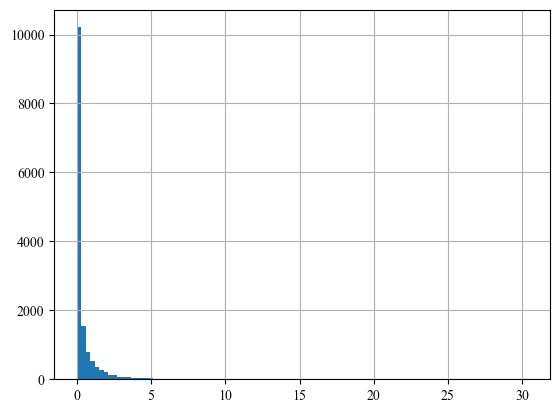

In [62]:
median_df["Gannon A/ph"].hist(bins=100)

Empty DataFrame
Columns: [sub_id, Transformer, latitude, longitude, pri, pri_abs]
Index: []
Generated all 1 combinations.
          sub_id         Transformer   latitude  longitude         pri  \
1206    42092946       42092946_auto  40.544289 -74.742741   87.121938   
1274    42678119       42678119_auto  40.240479 -74.518498   80.165761   
1396   136962270  136962270_non_auto  42.131370 -71.268338   78.492371   
2248    82442537   82442537_non_auto  37.502674 -77.704012  112.541960   
2576    94761499   94761499_non_auto  40.405528 -74.485289  106.453425   
3086    41742985       41742985_auto  40.171544 -75.310013   96.807657   
6042   295953491      295953491_auto  39.515597 -77.917334   77.739227   
13068   94783939   94783939_non_auto  40.819880 -74.330838  103.554673   
13076   81529768   81529768_non_auto  43.141744 -71.184804   83.121766   
13264  140295802  140295802_non_auto  41.391726 -73.402171   98.748583   

          pri_abs  
1206    87.121938  
1274    80.165761  
139

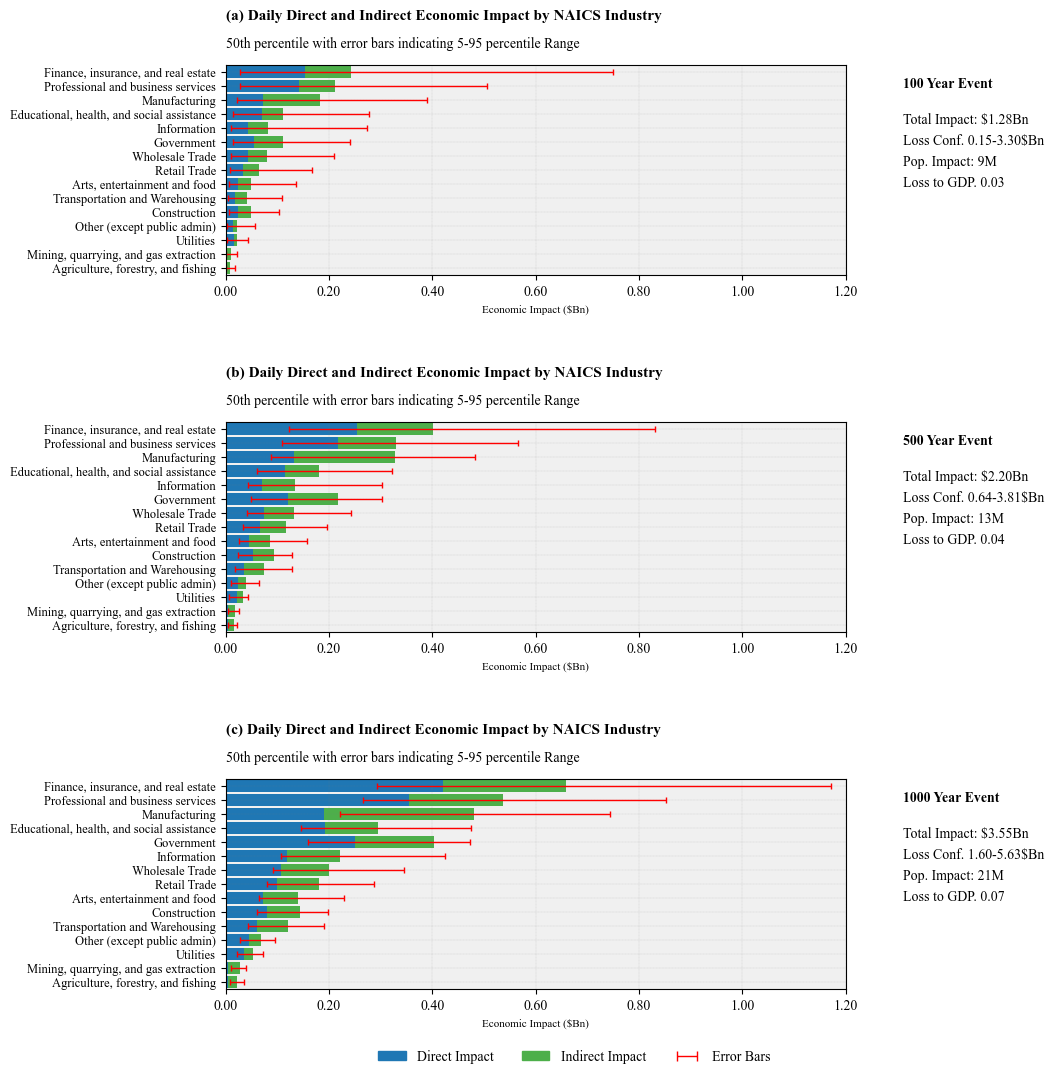

Empty DataFrame
Columns: [sub_id, Transformer, latitude, longitude, pri, pri_abs]
Index: []
Generated all 1 combinations.
          sub_id         Transformer   latitude  longitude         pri  \
1206    42092946       42092946_auto  40.544289 -74.742741   81.764237   
1274    42678119       42678119_auto  40.240479 -74.518498   82.723841   
1398   136962270      136962270_auto  42.131370 -71.268338   87.041410   
2248    82442537   82442537_non_auto  37.502674 -77.704012  101.431580   
2576    94761499   94761499_non_auto  40.405528 -74.485289  100.042433   
3086    41742985       41742985_auto  40.171544 -75.310013   83.415760   
13068   94783939   94783939_non_auto  40.819880 -74.330838   94.182857   
13078   81529768       81529768_auto  43.141744 -71.184804   85.441717   
13264  140295802  140295802_non_auto  41.391726 -73.402171   91.521794   

          pri_abs  
1206    81.764237  
1274    82.723841  
1398    87.041410  
2248   101.431580  
2576   100.042433  
3086    83.415760

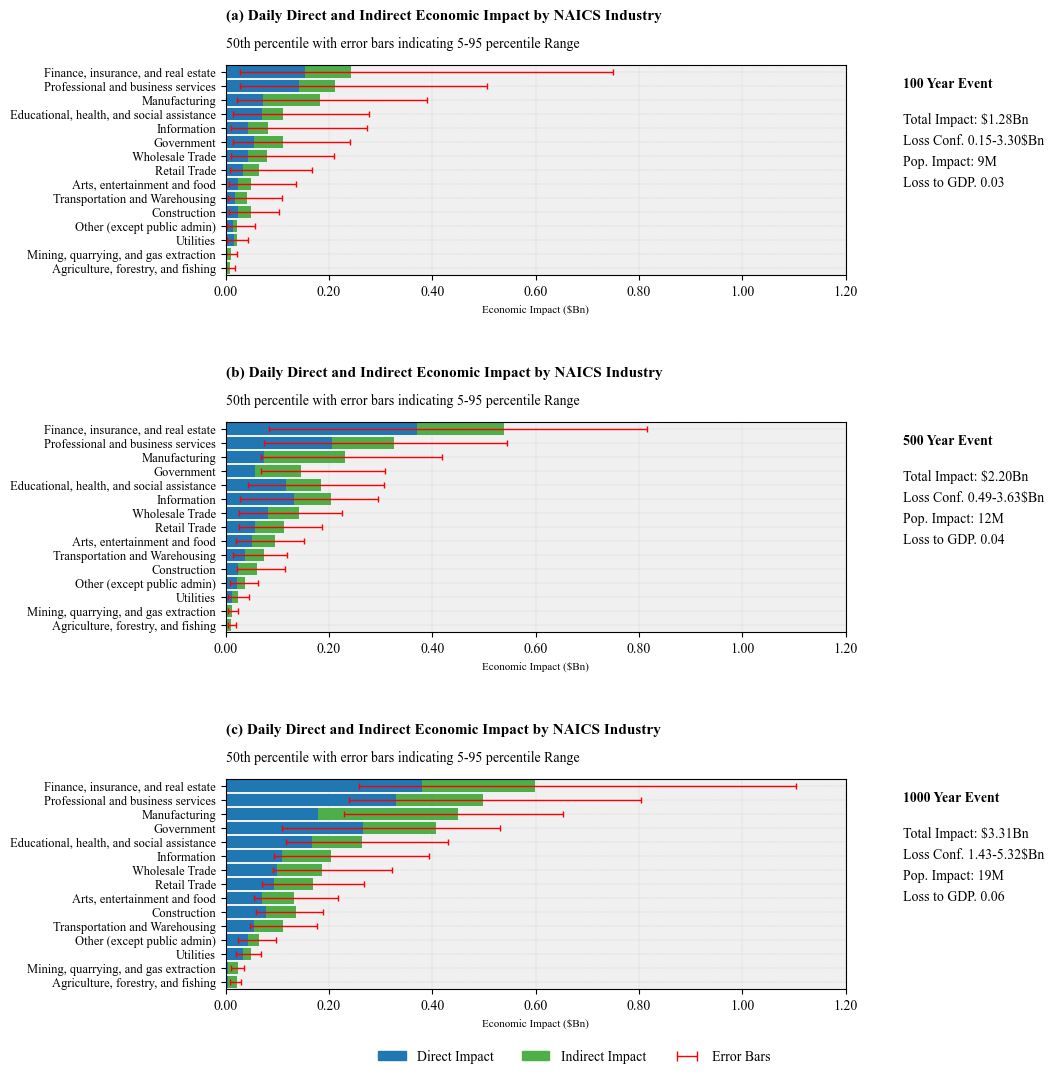

In [63]:
for i, path_data in enumerate(["winding_mean_df.csv", "winding_median_df.csv"]):

    storm_data = [
        {
            "file_path": path_data,
            "col": "Gannon A/ph",
            "title": "Daily Direct and Indirect Economic Impact by NAICS Industry",
            "sub_title": "50th percentile with error bars indicating 5-95 percentile Range",
            "scenario_title": "2024 Storm Gannon",
        },
        {
            "file_path": path_data,
            "col": "100-year-hazard A/ph",
            "title": "Daily Direct and Indirect Economic Impact by NAICS Industry",
            "sub_title": "50th percentile with error bars indicating 5-95 percentile Range",
            "scenario_title": "100 Year Event",
        },
        {
            "file_path": path_data,
            "col": "500-year-hazard A/ph",
            "title": "Daily Direct and Indirect Economic Impact by NAICS Industry",
            "sub_title": "50th percentile with error bars indicating 5-95 percentile Range",
            "scenario_title": "500 Year Event",
        },
        {
            "file_path": path_data,
            "col": "1000-year-hazard A/ph",
            "title": "Daily Direct and Indirect Economic Impact by NAICS Industry",
            "sub_title": "50th percentile with error bars indicating 5-95 percentile Range",
            "scenario_title": "1000 Year Event",
        }
    ]
        
    for idx, data in enumerate(storm_data):
      df_impact, economic_shocks_dict = calculate_economic_impact(data["file_path"], data["col"])
      percentile_5_va, percentile_50_va, percentile_95_va = find_percentile_indices(df_impact, economic_shocks_dict)
    
      percentiles = {
          "5": percentile_5_va,
          "50": percentile_50_va,
          "95": percentile_95_va
      }
    
      # Get economic props
      economic_props = get_gdp_pop(economic_shocks_dict)
    
      # Append to storm data
      storm_data[idx]["percentiles"] = percentiles
    
      # socio-economic props
      storm_data[idx]["economic_props"] = economic_props
    
    fig= plt.figure(figsize=(8, 12))
    gs = gridspec.GridSpec(3, 1, figure=fig, wspace=0.3, hspace=0.7)
    
    x_axis_limts = (0, 1.2)
    if i == 1:
        x_axis_limts = (0, 1.2)
    
    for idx, data in enumerate(storm_data[1:]):
    
      # Show legend in the last
      if idx == 2:
        show_legend_bars = True
      else:
        show_legend_bars = False
    
      ax = fig.add_subplot(gs[idx])
    
      percentile_5_va = data["percentiles"]["5"]
      percentile_50_va = data["percentiles"]["50"]
      percentile_95_va = data["percentiles"]["95"]
    
      economic_props = data["economic_props"]
    
      ax = indirect_impact_plot_with_errorbars(
        fig,
        ax,
        percentile_50_va,
        percentile_5_va,
        percentile_95_va,
        x_axis_limts=x_axis_limts,
        scenario_title=data['scenario_title'],
        show_legend_bars=show_legend_bars,
        econ_props=economic_props
      )
      if show_legend_bars:
          ax, legend_elements = ax
          fig.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(0.3, 0.07), ncol=4, frameon=False, fontsize=10)
    
      ax.text(0.0, 1.2, f"({letters[idx]}) {storm_data[idx]['title']}", transform=ax.transAxes, ha='left', va='bottom', fontweight="bold", fontsize=11)
      ax.text(0.0, 1.07, f"{storm_data[idx]['sub_title']}", transform=ax.transAxes, ha='left', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig(f"{path_data.split("_")[1]}_indirect_impact_plot.png", dpi=300, bbox_inches='tight')

In [64]:
# fig= plt.figure(figsize=(8, 12))
# gs = gridspec.GridSpec(3, 1, figure=fig, wspace=0.3, hspace=0.7)

# x_axis_limts = (0, 1.1)

# for idx, data in enumerate(storm_data[1:]):

#   # Show legend in the last
#   if idx == 2:
#     show_legend_bars = True
#   else:
#     show_legend_bars = False

#   ax = fig.add_subplot(gs[idx])

#   percentile_5_va = data["percentiles"]["5"]
#   percentile_50_va = data["percentiles"]["50"]
#   percentile_95_va = data["percentiles"]["95"]

#   economic_props = data["economic_props"]

#   ax = indirect_impact_plot_with_errorbars(
#     fig,
#     ax,
#     percentile_50_va,
#     percentile_5_va,
#     percentile_95_va,
#     x_axis_limts=x_axis_limts,
#     scenario_title=data['scenario_title'],
#     show_legend_bars=show_legend_bars,
#     econ_props=economic_props
#   )
#   ax.text(0.0, 1.2, f"({letters[idx]}) {storm_data[idx]['title']}", transform=ax.transAxes, ha='left', va='bottom', fontweight="bold", fontsize=11)
#   ax.text(0.0, 1.07, f"{storm_data[idx]['sub_title']}", transform=ax.transAxes, ha='left', va='bottom', fontsize=10)

# plt.tight_layout()
# plt.show()

# fig.savefig("indirect_impact_plot.png", dpi=300, bbox_inches='tight')

In [65]:
# Read the filtered transmission lines
# Load data from preprocess storm data
df_lines_path = "../final_tl_data.pkl"
line_coords_file = "../line_coords.pkl"

# Read pickle function
def read_pickle(file):
    with open(file, "rb") as f:
        return pickle.load(f)

transmission_lines_csv = "../transmission_lines.csv"
substation_info_csv = "../substation_info.csv"

line_coordinates, valid_indices = read_pickle(line_coords_file)
df_lines = pd.read_csv(transmission_lines_csv)
substation_info = pd.read_csv(substation_info_csv)

In [66]:
df_lines.head(5)

,name,from_bus,to_bus,length,V,geometry,R_per_km,R
0,123813,6451,1287,44.057751,345.0,LINESTRING (-70.55336703699997 43.663321469000...,0.0283,1.246834
1,139465,6451,1287,43.931118,345.0,LINESTRING (-70.20368725199998 43.931649869000...,0.0283,1.243251
2,140839,6451,1303,49.292317,345.0,LINESTRING (-70.20368725199998 43.931649869000...,0.0283,1.394973
3,129610,6451,1303,49.256852,345.0,LINESTRING (-70.20368725199998 43.931649869000...,0.0283,1.393969
4,103157,6451,5535,21.598535,345.0,LINESTRING (-70.20362106399995 43.781401426000...,0.0283,0.611239


In [67]:
# Line_collection
# Define color map for voltage levels
voltage_colors = {
    230.: '#3498db',  # Light blue
    345.: '#2ecc71',  # Emerald green
    500.: '#9b59b6',   # Amethyst purple
    765.: '#e74c3c',  # Bright red
}
def plot_transmission_lines(
    ax,
    line_coordinates,
    voltages,
    voltage_colors,
    max_width=2,
    alpha=0.7,
):
    """
    Plot straight transmission lines on a map with color and thickness based on voltage levels.
    Parameters:
    - ax: matplotlib axis with cartopy projection
    - line_coordinates: list of numpy arrays containing line coordinates
    - voltages: list or array of voltage values for each line
    - voltage_colors: dictionary mapping voltage levels to colors
    - max_width: maximum width for the thickest lines (default: 2)
    - alpha: transparency of the lines (default: 0.7)
    Returns:
    - line_collection: the plotted LineCollection
    """
    if not line_coordinates:
        print("No valid line segments found.")
        return None

    # Generate straight lines using only start and end points
    straight_lines = []
    for line in line_coordinates:
        if len(line) >= 2:
            straight_lines.append([line[0], line[-1]])  # Use only first and last points

    # Assign colors based on voltage levels
    line_colors = [voltage_colors.get(v, 'gray') for v in voltages]  # 'gray' for unknown voltages

    # Scale line widths based on voltage, with max voltage having width 2
    max_voltage = max(voltages)
    line_widths = [max_width * (v / max_voltage) for v in voltages]

    line_collection = LineCollection(
        straight_lines,
        colors=line_colors,
        linewidths=line_widths,
        alpha=alpha,
        transform=ccrs.PlateCarree(),
    )

    ax.add_collection(line_collection)

    return line_collection

# %%
# Set up map
def setup_map(ax, spatial_extent=[-125, -66.5, 24, 50]):
    ax.set_extent(spatial_extent, ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor="#F0F0F0")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor="grey")
    # ax.add_feature(cfeature.STATES, linewidth=0.4, edgecolor="#E6F3FF")
    ax.add_feature(cfeature.LAKES, alpha=0.5, linewidth=0.5, edgecolor="grey")

    gl = ax.gridlines(
        draw_labels=False, linewidth=0.2, color="grey", alpha=0.5, linestyle="--"
    )

    return ax


def plot_substations(ax, df_substations, outer_color='#f39c12', inner_color='white', size=100, alpha=0.8, zorder=1):
    lons = df_substations["longitude"]
    lats = df_substations["latitude"]
    
    # Plot thick outer circle
    scatter_outer = ax.scatter(
        lons,
        lats,
        transform=ccrs.PlateCarree(),
        color=outer_color,
        s=size/4,
        alpha=alpha,
        edgecolors='black',
        linewidth=0.5,
        zorder=zorder,
    )
    
    # # Plot smaller inner circle
    # scatter_inner = ax.scatter(
    #     lons,
    #     lats,
    #     transform=ccrs.PlateCarree(),
    #     color=inner_color,
    #     s=size/4,  # Significantly smaller than the outer circle
    #     alpha=1,
    #     zorder=zorder+1,
    # )
    
    return scatter_outer

In [68]:
def create_custom_legend(ax, voltage_colors, substation_color):
    # Create legend elements for transmission lines
    voltage_elements = [mpatches.Patch(color=color, label=f'{voltage} kV')
                        for voltage, color in voltage_colors.items()]
    
    # Create legend element for substations
    substation_element = mlines.Line2D([], [], color=substation_color, marker='o', 
                                       linestyle='None', markersize=10, markeredgecolor='black',
                                       label='Substation')
    
    # Combine all legend elements
    legend_elements = voltage_elements + [substation_element]
    
    # Get the position of the main axes
    bbox = ax.get_position()
    
    # Create a new axis for the legend
    legend_ax = fig.add_axes([bbox.x1 + 0.01, bbox.y0, 0.1, bbox.height])
    legend_ax.axis('off')  # Turn off axis lines and labels
    
    # Add the legend to the new axis
    legend = legend_ax.legend(handles=legend_elements, loc='lower left', 
                              frameon=False, fontsize=10)

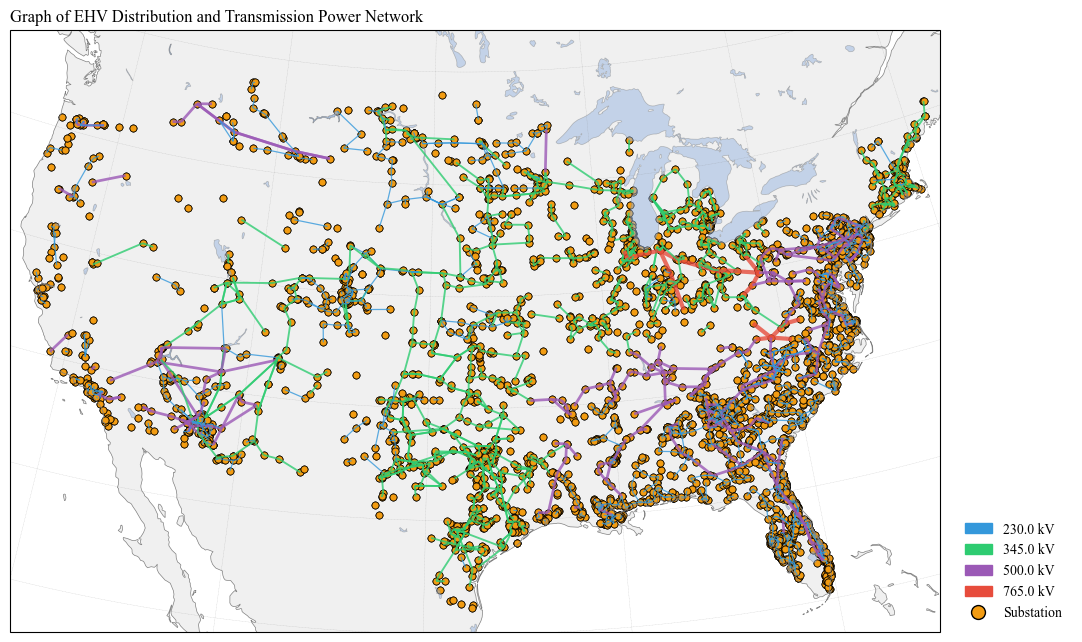

In [69]:
projection = ccrs.LambertConformal(central_longitude=-98, central_latitude=39.5)
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(1, 1, figure=fig, wspace=0.3, hspace=0.01)
ax = fig.add_subplot(gs[0], projection=projection)
spatial_extent=[-120, -75, 25, 50]
# Setup the map
ax = setup_map(ax, spatial_extent)

voltages = df_lines.V.values

# Plot transmission lines
plot_transmission_lines(ax, line_coordinates, voltages, voltage_colors=voltage_colors, max_width=3, alpha=0.8)

substation_color = '#f39c12'  # Orange
plot_substations(ax, mean_df, outer_color=substation_color)

# Create and add the custom legend
create_custom_legend(ax, voltage_colors, substation_color)
ax.set_title('Graph of EHV Distribution and Transmission Power Network', loc="left", fontsize=12)
plt.tight_layout()
plt.show()
plt.show()

fig.savefig("network.png", bbox_inches="tight", dpi=300)

In [70]:
# # Load 1000 year event gic
# df_gic_100_path = "winding_mean_df.csv"
# failed_transformers = get_failed_transformers(df_gic_100_path)

# # Viz
# econ_impact_viz(failed_transformers, sub_2_sub, substation_to_lines, subs_all_gdf,
#          zcta_business_gdf, regions_pop_df, haversine_distance_and_components,
#          transmission_lines, states_gdf, voltage_color_map)

In [72]:
def failed_trafos_stats(df, states_gdf=None, storm_col='100-year-hazard A/ph'):
    # Load the failed transformers data
    df['Winding_Type'] = np.where(df['Winding'].isin(['HV', 'Series']), 'Primary', 'Secondary')
    
    df[storm_col] = df[storm_col].abs()
    
    # Pivot the data to get Primary and Secondary values
    pivoted_df = df.pivot_table(
        index='Transformer',  # Set Transformer as the index
        columns='Winding_Type',
        values=storm_col,
        aggfunc='first'  # Get the first instance, assuming unique values per group
    ).reset_index()
    
    # Merge latitude and longitude back into the pivoted DataFrame
    pivoted_df = pivoted_df.merge(
        median_df[['Transformer', 'latitude', 'longitude']].drop_duplicates(),
        on='Transformer',
        how='left'
    )
    
    # Reorder columns for readability
    pivoted_df = pivoted_df[['Transformer', 'latitude', 'longitude', 'Primary', 'Secondary']]

    pivoted_df = pivoted_df[pivoted_df['Primary'] > 74]

    # Intersect with state gdf and get where most of the substations are
    if states_gdf is not None:
        # Create a GeoDataFrame from failed_transformers
        failed_transformers_gdf = gpd.GeoDataFrame(
            pivoted_df,
            geometry=gpd.points_from_xy(pivoted_df.longitude, pivoted_df.latitude),
            crs="EPSG:4326"
        )

        # Perform spatial join with states_gdf
        substations_by_state = gpd.sjoin(failed_transformers_gdf, states_gdf, how="left", predicate="within")

    return substations_by_state[['Transformer', 'latitude', 'longitude', 'Primary', 'Secondary','NAME']]

results = failed_trafos_stats(mean_df, states_gdf, storm_col='1000-year-hazard A/ph')

In [102]:
def analyze_economic_impact(data):
    economic_props = data["economic_props"]
    percentile_5_va = data["percentiles"]["5"]
    percentile_50_va = data["percentiles"]["50"]
    percentile_95_va = data["percentiles"]["95"]

    analysis = {
        "Total Population": economic_props["pop"],
        "Impact Summary": {
            "5th Percentile": {
                "Direct Impact": percentile_5_va["Direct Impact"].sum(),
                "Indirect Impact": percentile_5_va["Indirect Impact"].sum(),
                "Total Impact": percentile_5_va["Total Impact"].sum()
            },
            "50th Percentile": {
                "Direct Impact": percentile_50_va["Direct Impact"].sum(),
                "Indirect Impact": percentile_50_va["Indirect Impact"].sum(),
                "Total Impact": percentile_50_va["Total Impact"].sum()
            },
            "95th Percentile": {
                "Direct Impact": percentile_95_va["Direct Impact"].sum(),
                "Indirect Impact": percentile_95_va["Indirect Impact"].sum(),
                "Total Impact": percentile_95_va["Total Impact"].sum()
            }
        },
        "Top Affected Sectors": percentile_95_va.sort_values("Total Impact", ascending=False).to_dict('records'),
        "Least Affected Sectors": percentile_95_va.sort_values("Total Impact", ascending=True).to_dict('records')
    }

    return analysis

In [210]:
# Analyze the data
summaries = {}
impact_dfs = {}

fail_trafos = []
dfs=[]
for idx in range(len(storm_data)):
    data = storm_data[idx]
    col = data["col"]
    results = analyze_economic_impact(data)
    failed_trafos = failed_trafos_stats(mean_df, states_gdf, storm_col=col)
    states_affected = failed_trafos.groupby("NAME")["Transformer"].count().sort_values(ascending=False)
    
    # Extracting the impact summary data
    impact_data = results['Impact Summary']
    
    # Creating the DataFrame
    impact_df = pd.DataFrame(impact_data).T
    impact_df.index.name = 'Percentile'
    impact_df.columns.name = 'Impact Type'
    impact_df['Storm'] = col
    impact_df[f"Population Impacted"] = results['Total Population']
    impact_df[f"Population Impacted (%)"] = round((results['Total Population'] / (total_pop/1000000))*100, 2)
    impact_dfs[col] = impact_df
    
    # # Print the results
    # print(f"Total Population: {results['Total Population']:,}")
    # print("\nImpact Summary:")
    # for percentile, impacts in results['Impact Summary'].items():
    #     print(f"  {percentile}:")
    #     for impact_type, value in impacts.items():
    #         print(f"    {impact_type}: ${value:,.2f}")
    
    # print("\nTop Affected Sectors:")
    # for sector in results['Top Affected Sectors']:
    #     print(f"  {sector['NAICSIndustries']}:")
    #     print(f"    Total Impact: ${sector['Total Impact']:,.2f}")
    #     print(f"    Direct Impact: ${sector['Direct Impact']:,.2f}")
    #     print(f"    Indirect Impact: ${sector['Indirect Impact']:,.2f}")
    
    # print("\nLeast Affected Sectors:")
    # for sector in results['Least Affected Sectors']:
    #     print(f"  {sector['NAICSIndustries']}:")
    #     print(f"    Total Impact: ${sector['Total Impact']:,.2f}")
    #     print(f"    Direct Impact: ${sector['Direct Impact']:,.2f}")
    #     print(f"    Indirect Impact: ${sector['Indirect Impact']:,.2f}")
    
    summary_data = {
    f"Event ({col.split('-')[0]})": [data["col"]] * len(results['Least Affected Sectors']),  # Assuming data["col"] represents the event identifier
    f"Sectorial Impact": [f"{sector['NAICSIndustries']}" for sector in results['Top Affected Sectors']],
    f"Cost ({col.split('-')[0]}-year event $bn)": [f"{sector['Total Impact']:,.2f}" for sector in results['Top Affected Sectors']],
    }

    df = pd.DataFrame(summary_data)
    dfs.append(df)

    if states_affected.index.tolist() != []:
        states_joined =  ", ".join([f"{state} ({states_affected.values.tolist()[i]})" for i, state in enumerate(states_affected.index.tolist())])
        fail_trafos.append({
            "Storm Event": col,
            "States":states_joined
            })
    summaries[col] = summary_data

In [187]:
# Export summaries
df_initial = dfs[1]
for i, df_ in enumerate(dfs[2:]):
    df_initial = df_initial.merge(df_, on="Sectorial Impact")
df_initial.to_csv("summaries_data.csv", index=False)

In [188]:
df_impact = pd.concat(list(impact_dfs.values())).reset_index()
df_impact["Direct Impact (%)"] = np.round((df_impact["Direct Impact"] / total_gdp)*100, 2) 
df_impact["Indirect Impact (%)"] = np.round((df_impact["Indirect Impact"] / total_gdp)*100, 2)
df_impact["Total Impact (%)"] = np.round((df_impact["Total Impact"] / total_gdp)*100, 2)
df_impact.to_csv("impacts.csv", index=False)

In [214]:
failed_trafos_df = pd.DataFrame(fail_trafos)
failed_trafos_df.to_csv("failed_trafos.csv", index=False)

In [ ]:
# Plot FN curve
plt.figure(figsize=(10, 6))

# Define the quantiles
quantiles = [0.01, 0.1, 0.5]
quantile_labels = ['1%', '10%', '50%']

# Substation failurs
sub_failures = df_impact['num_substations_failed'].unique()

# Lopp through sub_failures
for i in sub_failures:

    df_scenario = df_impact[df_impact['num_substations_failed'] == i]

    # Sort by 'total_gdp_impact' for plotting
    df_scenario = df_scenario.sort_values('total_gdp_impact', ascending=True)

    # Calculate the cumulative frequency 'Fi'
    n = len(df_scenario)
    df_scenario['Fi'] = df_scenario['total_gdp_impact'].rank(ascending=False) / (n + 1)

    # Plot the cumulative frequency curve
    plt.plot(df_scenario['total_gdp_impact'], df_scenario['Fi'], linestyle='-', label=f'{i}')

# Set the y-axis to log scale
plt.yscale('log')

# Add horizontal lines for each quantile value of Fi and label them
for value, label in zip(quantiles, quantile_labels):
  plt.axhline(y=value, color='k', linestyle='--')
  plt.text(x=max(df_scenario['total_gdp_impact']), y=value, s=f' {label} CP', color='k', va='bottom', ha='right')

# Add labels and title
plt.xlabel('Total GDP Imapact')
plt.ylabel('Cumulative Frequency')
plt.title('F-N Cumulative Frequency Curves for Multiple Grid Failure Regions')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False)

# Add a text object to act as a legend title
plt.text(x=0.1, y=-0.1, s='Number of\n Regions', ha='center', va='top', transform=plt.gca().transAxes,  weight='bold')
plt.grid(True)
plt.show()